# Image Generation via Generative Adversarial Networks

## import libraries

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm import tqdm
import os

## load data

In [2]:
directory_data  = './'
filename_data   = 'assignment_12_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))
real            = data['real_images']

In [3]:
print('size of real data:', real.shape)

size of real data: (4324, 32, 32)


## plot data

In [4]:
def plot_image(title, image):
    
    nRow = 3
    nCol = 4
    size = 3
    
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)
   
    for r in range(nRow): 
        for c in range(nCol):
            k = c * 300 + r * nCol * 300
            axes[r, c].imshow(image[k], cmap='gray')

    plt.tight_layout()
    plt.show()

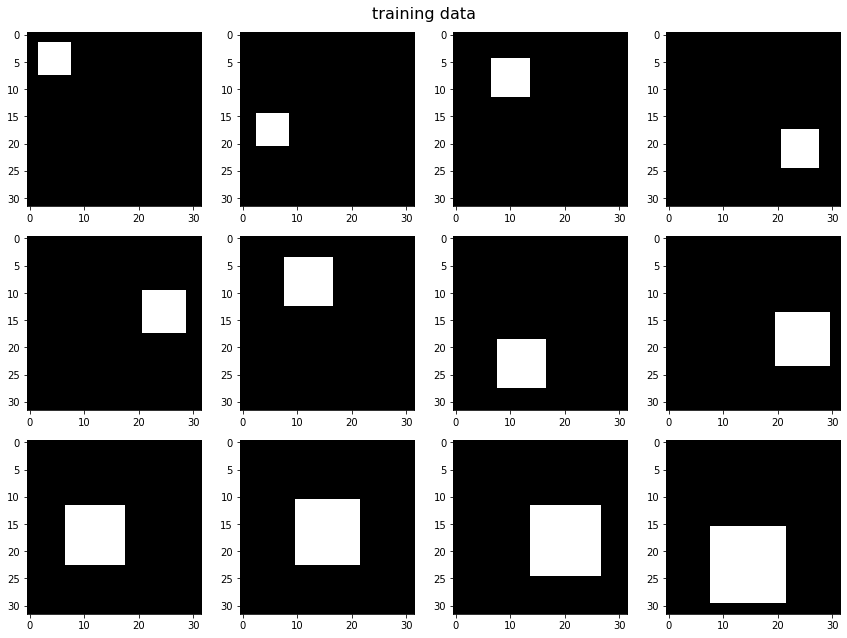

In [5]:
plot_image('training data', real)

## custom data loader for the PyTorch framework

In [6]:
class dataset(Dataset):
    
    def __init__(self, image):
        
        self.image = image
    
    def __getitem__(self, index):
        
        sample  = self.image[index]
        sample  = torch.FloatTensor(sample).unsqueeze(dim=0)

        return (sample)
    
    def __len__(self):

        number_image = len(self.image)

        return (number_image)

## setting device

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

In [8]:
print(device)

cuda


In [9]:
# random seed
import random
random.seed(20184757)
np.random.seed(20184757)
torch.manual_seed(20184757)
torch.cuda.manual_seed(20184757)
torch.cuda.manual_seed_all(20184757)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## construct datasets and dataloaders 

In [10]:
size_minibatch  = 32
dim_latent      = 64 # input latent vector fixed dimension 

dataset_real    = dataset(real)
dataloader_real = torch.utils.data.DataLoader(dataset_real, batch_size=size_minibatch, shuffle=True, drop_last=True)

## neural networks 

In [11]:
class Discriminator(nn.Module): 
    
    def __init__(self):
        
        super(Discriminator, self).__init__()
        
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256, out_features=128, bias=True),
            nn.LeakyReLU(0.2),
            
            nn.Linear(in_features=128, out_features=64, bias=True),
            nn.LeakyReLU(0.2),
            
            nn.Linear(in_features=64, out_features=32, bias=True),
            nn.LeakyReLU(0.2),
            
            nn.Linear(in_features=32, out_features=16, bias=True),
            nn.LeakyReLU(0.2),
            
            nn.Linear(in_features=16, out_features=1, bias=True),
        )
        
        self.network = nn.Sequential(
            self.feature,
            nn.Flatten(),
            self.classifier,
        )
        
    def forward(self, x):
        out = self.network(x)
        return out


In [12]:
class Generator(nn.Module):
    
    def __init__(self):
        
        super(Generator, self).__init__()
        
        self.network = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=dim_latent, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
            
            nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.network(x)
        return out

## build network

In [13]:
generator       = Generator().to(device)
discriminator   = Discriminator().to(device)

optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))

## compute the prediction

In [14]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the accuracy

In [15]:
def compute_bounding_mask(prediction_binary):
    
    bounding_mask = torch.zeros_like(prediction_binary)
    
    for i in range(prediction_binary.shape[0]):
        prediction = prediction_binary[i]
        (idx_row, idx_col) = torch.nonzero(prediction, as_tuple=True)
        
        if len(idx_row) > 0: 
            idx_row_min = idx_row.min()
            idx_row_max = idx_row.max()
        
            idx_col_min = idx_col.min()
            idx_col_max = idx_col.max()
    
            bounding_mask[i, idx_row_min:idx_row_max+1, idx_col_min:idx_col_max+1] = 1 
    
    return bounding_mask

In [16]:
def compute_accuracy(prediction):

    binary      = (prediction >= 0.5)
    mask        = compute_bounding_mask(binary)
    
    intersection = (binary & mask).float().sum((1, 2))
    union        = (binary | mask).float().sum((1, 2))

    eps         = 1e-8
    correct     = (intersection + eps) / (union + eps)
    accuracy    = correct.mean() * 100.0
    accuracy    = accuracy.cpu() 
    
    return accuracy

## train

In [17]:
def train(generator, discriminator, dataloader):
    
    loss_generator_epoch = []
    loss_discriminator_epoch = []
    
    for index_batch, (real) in enumerate(dataloader):
        real        = real.to(device)
        size_batch  = len(real)
        latent      = torch.randn(size_batch, dim_latent, device=device)
        latent      = torch.reshape(latent, [size_batch, dim_latent, 1, 1])

        # ---------------------------------------------------------------------------
        #  
        # update the generator
        #  
        # ---------------------------------------------------------------------------
        generator.train()
        discriminator.eval()
        
        optimizer_generator.zero_grad()
        fake = compute_prediction(generator, latent)
#         loss_image = nn.BCELoss()(fake, real)
        prediction_fake = compute_prediction(discriminator, fake)
        label_fake = torch.ones_like(prediction_fake)
        loss_label = nn.BCEWithLogitsLoss()(prediction_fake, label_fake)
#         loss_generator = 0.1 * loss_image + loss_label
        loss_generator = loss_label
        loss_generator.backward()
        optimizer_generator.step()

        # ---------------------------------------------------------------------------
        #  
        # update the discriminator
        #  
        # ---------------------------------------------------------------------------
        generator.eval()
        discriminator.train()
        
        optimizer_discriminator.zero_grad()
        fake = compute_prediction(generator, latent)
        prediction_real = compute_prediction(discriminator, real)
        prediction_fake = compute_prediction(discriminator, fake)
        loss_real = nn.BCEWithLogitsLoss()(prediction_real, torch.ones((size_batch, 1), device=device))
        loss_fake = nn.BCEWithLogitsLoss()(prediction_fake, torch.zeros((size_batch, 1), device=device))
        loss_discriminator = loss_real + loss_fake
        loss_discriminator.backward()
        optimizer_discriminator.step()
        
        loss_generator_epoch.append(loss_generator.item())
        loss_discriminator_epoch.append(loss_discriminator.item())
    
    return np.mean(loss_generator_epoch), np.mean(loss_discriminator_epoch)
        

## test

In [18]:
def test(generator, latent):
    
    generator.eval()
    
    prediction  = generator(latent)
    prediction  = prediction.squeeze(axis=1)
    accuracy    = compute_accuracy(prediction)
    
    return accuracy

## training epoch

In [19]:
number_epoch    = 500
accuracy_epoch  = np.zeros(number_epoch)
loss_generator = np.zeros(number_epoch)
loss_discriminator = np.zeros(number_epoch)

num_latent_test = 100
latent_test = torch.randn(num_latent_test, dim_latent, device=device)
latent_test = torch.reshape(latent_test, [num_latent_test, dim_latent, 1, 1])

for i in tqdm(range(number_epoch)):
    loss_generator_epoch, loss_discriminator_epoch = train(generator, discriminator, dataloader_real)
    accuracy = test(generator, latent_test)
    accuracy_epoch[i] = accuracy
    
    print(f'epoch {i}, loss_generator = {loss_generator_epoch}, loss_discriminator={loss_discriminator_epoch}')
    loss_generator[i] = loss_generator_epoch
    loss_discriminator[i] = loss_discriminator_epoch

  0%|▏                                                                                  | 1/500 [00:05<47:39,  5.73s/it]

epoch 0, loss_generator = 0.7009085057924191, loss_discriminator=0.2893844631707503


  0%|▎                                                                                  | 2/500 [00:09<39:00,  4.70s/it]

epoch 1, loss_generator = 0.005862065162337213, loss_discriminator=0.0035542708735361145


  1%|▍                                                                                  | 3/500 [00:13<36:12,  4.37s/it]

epoch 2, loss_generator = 0.002424381280973278, loss_discriminator=0.0009187065470204861


  1%|▋                                                                                  | 4/500 [00:17<34:50,  4.22s/it]

epoch 3, loss_generator = 0.0013994946179014666, loss_discriminator=0.0004732087617783152


  1%|▊                                                                                  | 5/500 [00:21<34:06,  4.13s/it]

epoch 4, loss_generator = 0.000878530036425218, loss_discriminator=0.00023603783925796892


  1%|▉                                                                                  | 6/500 [00:25<33:34,  4.08s/it]

epoch 5, loss_generator = 0.5239729734790873, loss_discriminator=0.20988370961125905


  1%|█▏                                                                                 | 7/500 [00:29<33:11,  4.04s/it]

epoch 6, loss_generator = 0.03252989970561531, loss_discriminator=0.0027486941377261515


  2%|█▎                                                                                 | 8/500 [00:33<32:41,  3.99s/it]

epoch 7, loss_generator = 0.0018880187710574655, loss_discriminator=0.0006218960075380488


  2%|█▍                                                                                 | 9/500 [00:37<32:34,  3.98s/it]

epoch 8, loss_generator = 0.0009483260173712754, loss_discriminator=0.00034927476770934407


  2%|█▋                                                                                | 10/500 [00:41<32:26,  3.97s/it]

epoch 9, loss_generator = 0.0005231241497245651, loss_discriminator=0.00034705486032180486


  2%|█▊                                                                                | 11/500 [00:45<32:15,  3.96s/it]

epoch 10, loss_generator = 0.0002685914064554877, loss_discriminator=0.00015664533590703893


  2%|█▉                                                                                | 12/500 [00:49<32:11,  3.96s/it]

epoch 11, loss_generator = 0.00019453766672759904, loss_discriminator=0.00012045379800029979


  3%|██▏                                                                               | 13/500 [00:53<32:07,  3.96s/it]

epoch 12, loss_generator = 0.0001614237591706182, loss_discriminator=0.00011753897089403364


  3%|██▎                                                                               | 14/500 [00:57<32:02,  3.96s/it]

epoch 13, loss_generator = 0.00011148031313765656, loss_discriminator=9.472592385767105e-05


  3%|██▍                                                                               | 15/500 [01:01<31:54,  3.95s/it]

epoch 14, loss_generator = 8.552526338058265e-05, loss_discriminator=6.952518238163233e-05


  3%|██▌                                                                               | 16/500 [01:05<31:50,  3.95s/it]

epoch 15, loss_generator = 7.588543025862977e-05, loss_discriminator=4.2414919698785523e-05


  3%|██▊                                                                               | 17/500 [01:08<31:45,  3.95s/it]

epoch 16, loss_generator = 6.411692818262425e-05, loss_discriminator=4.048782796720237e-05


  4%|██▉                                                                               | 18/500 [01:12<31:42,  3.95s/it]

epoch 17, loss_generator = 5.215207614431468e-05, loss_discriminator=2.612622698439669e-05


  4%|███                                                                               | 19/500 [01:16<31:39,  3.95s/it]

epoch 18, loss_generator = 4.6698822781629e-05, loss_discriminator=3.1342898815906935e-05


  4%|███▎                                                                              | 20/500 [01:20<31:29,  3.94s/it]

epoch 19, loss_generator = 4.053497964546464e-05, loss_discriminator=2.1539277279063955e-05


  4%|███▍                                                                              | 21/500 [01:24<31:26,  3.94s/it]

epoch 20, loss_generator = 3.3791565524384e-05, loss_discriminator=2.265998571231278e-05


  4%|███▌                                                                              | 22/500 [01:28<31:23,  3.94s/it]

epoch 21, loss_generator = 2.7990263273143986e-05, loss_discriminator=1.80119304803628e-05


  5%|███▊                                                                              | 23/500 [01:32<31:19,  3.94s/it]

epoch 22, loss_generator = 2.454834031798075e-05, loss_discriminator=1.9689982915830722e-05


  5%|███▉                                                                              | 24/500 [01:36<31:12,  3.93s/it]

epoch 23, loss_generator = 2.214982181343388e-05, loss_discriminator=1.4210268197227076e-05


  5%|████                                                                              | 25/500 [01:40<31:09,  3.93s/it]

epoch 24, loss_generator = 2.174463997343318e-05, loss_discriminator=1.418598154419602e-05


  5%|████▎                                                                             | 26/500 [01:44<31:05,  3.93s/it]

epoch 25, loss_generator = 1.9483551774033846e-05, loss_discriminator=1.0573136853929976e-05


  5%|████▍                                                                             | 27/500 [01:48<31:02,  3.94s/it]

epoch 26, loss_generator = 1.686481019970853e-05, loss_discriminator=9.121739436455687e-06


  6%|████▌                                                                             | 28/500 [01:52<30:32,  3.88s/it]

epoch 27, loss_generator = 1.698597357231106e-05, loss_discriminator=9.149734051384762e-06


  6%|████▊                                                                             | 29/500 [01:55<29:58,  3.82s/it]

epoch 28, loss_generator = 1.5453351978875515e-05, loss_discriminator=8.254941952111916e-06


  6%|████▉                                                                             | 30/500 [01:59<29:21,  3.75s/it]

epoch 29, loss_generator = 1.4298273200202621e-05, loss_discriminator=7.670348428392673e-06


  6%|█████                                                                             | 31/500 [02:03<29:02,  3.72s/it]

epoch 30, loss_generator = 1.2632909389746299e-05, loss_discriminator=6.370559102227465e-06


  6%|█████▏                                                                            | 32/500 [02:06<28:32,  3.66s/it]

epoch 31, loss_generator = 1.187011826847016e-05, loss_discriminator=6.518609714273932e-06


  7%|█████▍                                                                            | 33/500 [02:10<28:27,  3.66s/it]

epoch 32, loss_generator = 1.1218424855609623e-05, loss_discriminator=5.393096544307978e-06


  7%|█████▌                                                                            | 34/500 [02:13<28:25,  3.66s/it]

epoch 33, loss_generator = 9.218572629968683e-06, loss_discriminator=8.834424968679539e-06


  7%|█████▋                                                                            | 35/500 [02:17<28:12,  3.64s/it]

epoch 34, loss_generator = 9.204414879638569e-06, loss_discriminator=4.798138383598092e-06


  7%|█████▉                                                                            | 36/500 [02:21<28:12,  3.65s/it]

epoch 35, loss_generator = 8.548338445069493e-06, loss_discriminator=5.006623546756196e-06


  7%|██████                                                                            | 37/500 [02:24<28:04,  3.64s/it]

epoch 36, loss_generator = 7.721888539014832e-06, loss_discriminator=4.187246847525077e-06


  8%|██████▏                                                                           | 38/500 [02:28<28:01,  3.64s/it]

epoch 37, loss_generator = 7.064835497456241e-06, loss_discriminator=3.823517189445098e-06


  8%|██████▍                                                                           | 39/500 [02:31<27:52,  3.63s/it]

epoch 38, loss_generator = 6.0189254832544575e-06, loss_discriminator=4.089882480474006e-06


  8%|██████▌                                                                           | 40/500 [02:35<27:51,  3.63s/it]

epoch 39, loss_generator = 5.568806985441673e-06, loss_discriminator=2.6728796384574066e-06


  8%|██████▋                                                                           | 41/500 [02:39<27:25,  3.59s/it]

epoch 40, loss_generator = 5.441597102583694e-06, loss_discriminator=3.789737909890526e-06


  8%|██████▉                                                                           | 42/500 [02:42<27:28,  3.60s/it]

epoch 41, loss_generator = 4.727397339155249e-06, loss_discriminator=2.8554759267165168e-06


  9%|███████                                                                           | 43/500 [02:46<27:31,  3.61s/it]

epoch 42, loss_generator = 4.4761738039327344e-06, loss_discriminator=2.537367408582146e-06


  9%|███████▏                                                                          | 44/500 [02:49<27:28,  3.61s/it]

epoch 43, loss_generator = 4.099651116323205e-06, loss_discriminator=1.789425545300421e-06


  9%|███████▍                                                                          | 45/500 [02:53<27:24,  3.61s/it]

epoch 44, loss_generator = 3.8009944142282216e-06, loss_discriminator=1.9083551444930856e-06


  9%|███████▌                                                                          | 46/500 [02:57<27:29,  3.63s/it]

epoch 45, loss_generator = 3.457829988865005e-06, loss_discriminator=1.581380157463004e-06


  9%|███████▋                                                                          | 47/500 [03:00<27:33,  3.65s/it]

epoch 46, loss_generator = 3.241074351215637e-06, loss_discriminator=2.8149427189797885e-06


 10%|███████▊                                                                          | 48/500 [03:04<27:16,  3.62s/it]

epoch 47, loss_generator = 2.585040856165169e-06, loss_discriminator=1.4635877005486219e-06


 10%|████████                                                                          | 49/500 [03:08<27:02,  3.60s/it]

epoch 48, loss_generator = 2.4070557241497293e-06, loss_discriminator=1.1420868666526211e-06


 10%|████████▏                                                                         | 50/500 [03:11<27:06,  3.61s/it]

epoch 49, loss_generator = 2.2565262653457735e-06, loss_discriminator=1.1071235531045643e-06


 10%|████████▎                                                                         | 51/500 [03:15<27:14,  3.64s/it]

epoch 50, loss_generator = 2.1628708884270087e-06, loss_discriminator=9.761581583023617e-07


 10%|████████▌                                                                         | 52/500 [03:19<27:33,  3.69s/it]

epoch 51, loss_generator = 2.000199859779699e-06, loss_discriminator=1.0025683555644113e-06


 11%|████████▋                                                                         | 53/500 [03:22<26:58,  3.62s/it]

epoch 52, loss_generator = 2.0618463226869437e-06, loss_discriminator=9.947236312276194e-07


 11%|████████▊                                                                         | 54/500 [03:26<26:57,  3.63s/it]

epoch 53, loss_generator = 1.7057935809606095e-06, loss_discriminator=1.0897800965242115e-06


 11%|█████████                                                                         | 55/500 [03:30<27:01,  3.64s/it]

epoch 54, loss_generator = 1.82144204190822e-06, loss_discriminator=8.255216953940631e-07


 11%|█████████▏                                                                        | 56/500 [03:33<26:57,  3.64s/it]

epoch 55, loss_generator = 1.6271484239664627e-06, loss_discriminator=7.066440684024269e-07


 11%|█████████▎                                                                        | 57/500 [03:37<26:58,  3.65s/it]

epoch 56, loss_generator = 1.5151969303470078e-06, loss_discriminator=7.394499587786851e-07


 12%|█████████▌                                                                        | 58/500 [03:40<26:51,  3.65s/it]

epoch 57, loss_generator = 1.4350067205955216e-06, loss_discriminator=9.058393785123911e-07


 12%|█████████▋                                                                        | 59/500 [03:44<26:40,  3.63s/it]

epoch 58, loss_generator = 1.394304453478307e-06, loss_discriminator=8.068656713762553e-07


 12%|█████████▊                                                                        | 60/500 [03:48<26:19,  3.59s/it]

epoch 59, loss_generator = 1.3585419320928916e-06, loss_discriminator=7.112234499381294e-07


 12%|██████████                                                                        | 61/500 [03:51<26:25,  3.61s/it]

epoch 60, loss_generator = 1.0247020702115185e-06, loss_discriminator=5.236359914167426e-07


 12%|██████████▏                                                                       | 62/500 [03:55<26:35,  3.64s/it]

epoch 61, loss_generator = 1.1359358164024039e-06, loss_discriminator=5.33847050963619e-07


 13%|██████████▎                                                                       | 63/500 [03:59<26:37,  3.66s/it]

epoch 62, loss_generator = 1.0199557250542865e-06, loss_discriminator=4.2614475774311384e-07


 13%|██████████▍                                                                       | 64/500 [04:02<26:38,  3.67s/it]

epoch 63, loss_generator = 9.821509125787189e-07, loss_discriminator=3.8604956935886194e-07


 13%|██████████▋                                                                       | 65/500 [04:06<26:29,  3.65s/it]

epoch 64, loss_generator = 9.636071131016823e-07, loss_discriminator=4.0986381565725576e-07


 13%|██████████▊                                                                       | 66/500 [04:10<26:29,  3.66s/it]

epoch 65, loss_generator = 8.756354247907439e-07, loss_discriminator=3.519703287408944e-07


 13%|██████████▉                                                                       | 67/500 [04:13<26:27,  3.67s/it]

epoch 66, loss_generator = 7.541359960012212e-07, loss_discriminator=4.348087535420996e-07


 14%|███████████▏                                                                      | 68/500 [04:17<26:00,  3.61s/it]

epoch 67, loss_generator = 7.058729067921377e-07, loss_discriminator=4.5439884799078655e-07


 14%|███████████▎                                                                      | 69/500 [04:20<25:53,  3.60s/it]

epoch 68, loss_generator = 6.684268900816851e-07, loss_discriminator=3.4559452474913353e-07


 14%|███████████▍                                                                      | 70/500 [04:24<25:38,  3.58s/it]

epoch 69, loss_generator = 6.714896972813154e-07, loss_discriminator=2.8447344323953467e-07


 14%|███████████▋                                                                      | 71/500 [04:28<25:51,  3.62s/it]

epoch 70, loss_generator = 6.368032601316102e-07, loss_discriminator=2.2144760393811363e-07


 14%|███████████▊                                                                      | 72/500 [04:31<25:36,  3.59s/it]

epoch 71, loss_generator = 5.749358704347456e-07, loss_discriminator=1.873681757664698e-07


 15%|███████████▉                                                                      | 73/500 [04:35<25:44,  3.62s/it]

epoch 72, loss_generator = 5.976463984114633e-07, loss_discriminator=2.2103362498329363e-07


 15%|████████████▏                                                                     | 74/500 [04:38<25:48,  3.64s/it]

epoch 73, loss_generator = 4.98995395048496e-07, loss_discriminator=2.655432954445513e-07


 15%|████████████▎                                                                     | 75/500 [04:42<25:36,  3.61s/it]

epoch 74, loss_generator = 4.91213636745737e-07, loss_discriminator=1.8800273747993296e-07


 15%|████████████▍                                                                     | 76/500 [04:46<25:34,  3.62s/it]

epoch 75, loss_generator = 4.564443816821882e-07, loss_discriminator=1.4291305501481746e-07


 15%|████████████▋                                                                     | 77/500 [04:49<25:42,  3.65s/it]

epoch 76, loss_generator = 4.162112600380607e-07, loss_discriminator=1.467210420532702e-07


 16%|████████████▊                                                                     | 78/500 [04:53<25:28,  3.62s/it]

epoch 77, loss_generator = 3.851671940074758e-07, loss_discriminator=1.4713500045004936e-07


 16%|████████████▉                                                                     | 79/500 [04:57<25:32,  3.64s/it]

epoch 78, loss_generator = 3.7553662855947954e-07, loss_discriminator=2.2817811060040196e-07


 16%|█████████████                                                                     | 80/500 [05:00<25:48,  3.69s/it]

epoch 79, loss_generator = 3.857466794251515e-07, loss_discriminator=1.519088365024383e-07


 16%|█████████████▎                                                                    | 81/500 [05:04<25:32,  3.66s/it]

epoch 80, loss_generator = 3.178361085760857e-07, loss_discriminator=2.3954822908170515e-07


 16%|█████████████▍                                                                    | 82/500 [05:08<25:51,  3.71s/it]

epoch 81, loss_generator = 2.555824070308669e-07, loss_discriminator=1.0850240029245971e-07


 17%|█████████████▌                                                                    | 83/500 [05:11<25:27,  3.66s/it]

epoch 82, loss_generator = 2.4677970284554044e-07, loss_discriminator=8.325326036299167e-08


 17%|█████████████▊                                                                    | 84/500 [05:15<24:58,  3.60s/it]

epoch 83, loss_generator = 2.5373356014129016e-07, loss_discriminator=8.579193758698714e-08


 17%|█████████████▉                                                                    | 85/500 [05:18<24:35,  3.56s/it]

epoch 84, loss_generator = 2.3350663695964614e-07, loss_discriminator=8.471579424300328e-08


 17%|██████████████                                                                    | 86/500 [05:22<25:06,  3.64s/it]

epoch 85, loss_generator = 1.9699881375890561e-07, loss_discriminator=9.238703848859744e-08


 17%|██████████████▎                                                                   | 87/500 [05:26<25:23,  3.69s/it]

epoch 86, loss_generator = 2.0392508535796543e-07, loss_discriminator=6.487520695961122e-08


 18%|██████████████▍                                                                   | 88/500 [05:30<25:22,  3.70s/it]

epoch 87, loss_generator = 2.0955442142028207e-07, loss_discriminator=7.031134159012024e-08


 18%|██████████████▌                                                                   | 89/500 [05:33<25:16,  3.69s/it]

epoch 88, loss_generator = 2.022417936692128e-07, loss_discriminator=7.406423172375667e-08


 18%|██████████████▊                                                                   | 90/500 [05:37<25:01,  3.66s/it]

epoch 89, loss_generator = 1.887203885246962e-07, loss_discriminator=1.9489858778881448e-07


 18%|██████████████▉                                                                   | 91/500 [05:41<25:01,  3.67s/it]

epoch 90, loss_generator = 1.935218695679084e-07, loss_discriminator=5.527224762160556e-08


 18%|███████████████                                                                   | 92/500 [05:44<24:50,  3.65s/it]

epoch 91, loss_generator = 1.9062441890003744e-07, loss_discriminator=5.5962078676435674e-08


 19%|███████████████▎                                                                  | 93/500 [05:48<24:41,  3.64s/it]

epoch 92, loss_generator = 1.6057374464158631e-07, loss_discriminator=4.464827432051179e-08


 19%|███████████████▍                                                                  | 94/500 [05:51<24:36,  3.64s/it]

epoch 93, loss_generator = 1.6520966708751435e-07, loss_discriminator=4.3599671941920964e-08


 19%|███████████████▌                                                                  | 95/500 [05:55<24:26,  3.62s/it]

epoch 94, loss_generator = 1.186849631511993e-07, loss_discriminator=4.9228976746936347e-08


 19%|███████████████▋                                                                  | 96/500 [05:59<24:28,  3.63s/it]

epoch 95, loss_generator = 1.2078212134151536e-07, loss_discriminator=3.090609984725114e-08


 19%|███████████████▉                                                                  | 97/500 [06:02<24:23,  3.63s/it]

epoch 96, loss_generator = 1.25969964257264e-07, loss_discriminator=2.1441110128513948e-08


 20%|████████████████                                                                  | 98/500 [06:06<24:23,  3.64s/it]

epoch 97, loss_generator = 1.0221090117160206e-07, loss_discriminator=3.129242686865323e-08


 20%|████████████████▏                                                                 | 99/500 [06:10<24:33,  3.67s/it]

epoch 98, loss_generator = 1.014382417898587e-07, loss_discriminator=3.6011122628710056e-08


 20%|████████████████▏                                                                | 100/500 [06:13<24:13,  3.63s/it]

epoch 99, loss_generator = 7.67685583645693e-08, loss_discriminator=2.0751240289892843e-08


 20%|████████████████▎                                                                | 101/500 [06:17<24:18,  3.66s/it]

epoch 100, loss_generator = 8.272902144076018e-08, loss_discriminator=2.4062605868340685e-08


 20%|████████████████▌                                                                | 102/500 [06:21<24:16,  3.66s/it]

epoch 101, loss_generator = 7.814829379993716e-08, loss_discriminator=1.7053548071630674e-08


 21%|████████████████▋                                                                | 103/500 [06:24<24:14,  3.66s/it]

epoch 102, loss_generator = 7.483691850909382e-08, loss_discriminator=1.7274304115528277e-08


 21%|████████████████▊                                                                | 104/500 [06:28<24:09,  3.66s/it]

epoch 103, loss_generator = 7.133238271995458e-08, loss_discriminator=2.5635499250958665e-08


 21%|█████████████████                                                                | 105/500 [06:32<24:01,  3.65s/it]

epoch 104, loss_generator = 4.2633871514633864e-08, loss_discriminator=1.2252064166510217e-08


 21%|█████████████████▏                                                               | 106/500 [06:35<23:47,  3.62s/it]

epoch 105, loss_generator = 3.849466095185295e-08, loss_discriminator=1.5011534509273222e-08


 21%|█████████████████▎                                                               | 107/500 [06:39<23:51,  3.64s/it]

epoch 106, loss_generator = 4.829078593794457e-08, loss_discriminator=2.5883849958858647e-08


 22%|█████████████████▍                                                               | 108/500 [06:43<23:53,  3.66s/it]

epoch 107, loss_generator = 2.999548167214738e-08, loss_discriminator=1.0844730938778205e-08


 22%|█████████████████▋                                                               | 109/500 [06:46<23:55,  3.67s/it]

epoch 108, loss_generator = 2.5387160150234808e-08, loss_discriminator=1.2555603179364993e-08


 22%|█████████████████▊                                                               | 110/500 [06:50<23:48,  3.66s/it]

epoch 109, loss_generator = 2.8919286252946952e-08, loss_discriminator=1.6308481266670407e-08


 22%|█████████████████▉                                                               | 111/500 [06:54<23:42,  3.66s/it]

epoch 110, loss_generator = 1.7108737819053014e-08, loss_discriminator=6.457168918079977e-09


 22%|██████████████████▏                                                              | 112/500 [06:57<23:51,  3.69s/it]

epoch 111, loss_generator = 1.7301901185836262e-08, loss_discriminator=4.553131779424554e-09


 23%|██████████████████▎                                                              | 113/500 [07:01<23:48,  3.69s/it]

epoch 112, loss_generator = 1.782620187594251e-08, loss_discriminator=6.070841814439139e-09


 23%|██████████████████▍                                                              | 114/500 [07:05<23:43,  3.69s/it]

epoch 113, loss_generator = 1.556343314635245e-08, loss_discriminator=5.8224898170356745e-09


 23%|██████████████████▋                                                              | 115/500 [07:08<23:35,  3.68s/it]

epoch 114, loss_generator = 1.920593873239585e-08, loss_discriminator=6.484762942264937e-09


 23%|██████████████████▊                                                              | 116/500 [07:12<23:19,  3.64s/it]

epoch 115, loss_generator = 1.2693580481376792e-08, loss_discriminator=3.835668888680428e-09


 23%|██████████████████▉                                                              | 117/500 [07:16<23:13,  3.64s/it]

epoch 116, loss_generator = 1.553583850537692e-08, loss_discriminator=4.939457973504899e-09


 24%|███████████████████                                                              | 118/500 [07:19<23:13,  3.65s/it]

epoch 117, loss_generator = 1.7577849120297838e-08, loss_discriminator=3.6701004605769564e-09


 24%|███████████████████▎                                                             | 119/500 [07:23<23:14,  3.66s/it]

epoch 118, loss_generator = 1.7136333086687763e-08, loss_discriminator=4.801484727507883e-09


 24%|███████████████████▍                                                             | 120/500 [07:27<23:15,  3.67s/it]

epoch 119, loss_generator = 1.0706759342490364e-08, loss_discriminator=4.580726611193966e-09


 24%|███████████████████▌                                                             | 121/500 [07:30<23:08,  3.66s/it]

epoch 120, loss_generator = 1.2279659391380816e-08, loss_discriminator=4.55313110671164e-09


 24%|███████████████████▊                                                             | 122/500 [07:34<23:03,  3.66s/it]

epoch 121, loss_generator = 9.630564410143291e-09, loss_discriminator=2.2351738468326285e-09


 25%|███████████████████▉                                                             | 123/500 [07:38<22:55,  3.65s/it]

epoch 122, loss_generator = 1.2252064546453206e-08, loss_discriminator=3.007826591909461e-09


 25%|████████████████████                                                             | 124/500 [07:41<22:55,  3.66s/it]

epoch 123, loss_generator = 1.0486001064988513e-08, loss_discriminator=2.207578959140872e-09


 25%|████████████████████▎                                                            | 125/500 [07:45<22:48,  3.65s/it]

epoch 124, loss_generator = 1.0817134039526806e-08, loss_discriminator=1.876442366097906e-09


 25%|████████████████████▍                                                            | 126/500 [07:49<22:58,  3.68s/it]

epoch 125, loss_generator = 8.443990614545079e-09, loss_discriminator=2.8698524363519524e-09


 25%|████████████████████▌                                                            | 127/500 [07:52<22:51,  3.68s/it]

epoch 126, loss_generator = 6.208816647643887e-09, loss_discriminator=2.0420107432133564e-09


 26%|████████████████████▋                                                            | 128/500 [07:56<22:41,  3.66s/it]

epoch 127, loss_generator = 1.1628374112218065, loss_discriminator=0.30384227319059054


 26%|████████████████████▉                                                            | 129/500 [07:59<22:34,  3.65s/it]

epoch 128, loss_generator = 0.0022198020021379408, loss_discriminator=0.002944313841268282


 26%|█████████████████████                                                            | 130/500 [08:03<22:35,  3.66s/it]

epoch 129, loss_generator = 0.0009233914889153783, loss_discriminator=0.0011622599239301593


 26%|█████████████████████▏                                                           | 131/500 [08:07<22:28,  3.66s/it]

epoch 130, loss_generator = 0.0004907358998833742, loss_discriminator=0.0005158609745935624


 26%|█████████████████████▍                                                           | 132/500 [08:10<22:21,  3.64s/it]

epoch 131, loss_generator = 0.0002473969675958398, loss_discriminator=0.000300858122891104


 27%|█████████████████████▌                                                           | 133/500 [08:14<22:16,  3.64s/it]

epoch 132, loss_generator = 0.0001691432577327187, loss_discriminator=0.00017623343667731172


 27%|█████████████████████▋                                                           | 134/500 [08:18<22:16,  3.65s/it]

epoch 133, loss_generator = 0.00014171011906809224, loss_discriminator=0.0001682810746489041


 27%|█████████████████████▊                                                           | 135/500 [08:21<22:10,  3.65s/it]

epoch 134, loss_generator = 0.00010361657936031137, loss_discriminator=0.00010852939125874805


 27%|██████████████████████                                                           | 136/500 [08:25<21:57,  3.62s/it]

epoch 135, loss_generator = 9.432013278085462e-05, loss_discriminator=0.0001011314056422971


 27%|██████████████████████▏                                                          | 137/500 [08:29<21:49,  3.61s/it]

epoch 136, loss_generator = 8.402816025341895e-05, loss_discriminator=6.802967638274519e-05


 28%|██████████████████████▎                                                          | 138/500 [08:32<21:58,  3.64s/it]

epoch 137, loss_generator = 7.814974065964904e-05, loss_discriminator=4.973043726716208e-05


 28%|██████████████████████▌                                                          | 139/500 [08:36<22:01,  3.66s/it]

epoch 138, loss_generator = 7.056625121616957e-05, loss_discriminator=4.958426844091769e-05


 28%|██████████████████████▋                                                          | 140/500 [08:40<22:08,  3.69s/it]

epoch 139, loss_generator = 5.8095722084140614e-05, loss_discriminator=4.196350143872594e-05


 28%|██████████████████████▊                                                          | 141/500 [08:43<22:08,  3.70s/it]

epoch 140, loss_generator = 5.35219596915542e-05, loss_discriminator=3.656350268270385e-05


 28%|███████████████████████                                                          | 142/500 [08:47<22:10,  3.72s/it]

epoch 141, loss_generator = 4.348533908611258e-05, loss_discriminator=4.7870525112877525e-05


 29%|███████████████████████▏                                                         | 143/500 [08:51<22:01,  3.70s/it]

epoch 142, loss_generator = 4.249849530255974e-05, loss_discriminator=2.816543631828002e-05


 29%|███████████████████████▎                                                         | 144/500 [08:55<21:55,  3.70s/it]

epoch 143, loss_generator = 3.973313357198128e-05, loss_discriminator=2.9089191896134622e-05


 29%|███████████████████████▍                                                         | 145/500 [08:58<21:51,  3.69s/it]

epoch 144, loss_generator = 2.712537433816814e-05, loss_discriminator=3.297200421541304e-05


 29%|███████████████████████▋                                                         | 146/500 [09:02<22:08,  3.75s/it]

epoch 145, loss_generator = 2.4678852039667414e-05, loss_discriminator=2.078680500593085e-05


 29%|███████████████████████▊                                                         | 147/500 [09:06<22:04,  3.75s/it]

epoch 146, loss_generator = 1.9968803024783956e-05, loss_discriminator=2.1602229708150844e-05


 30%|███████████████████████▉                                                         | 148/500 [09:09<21:46,  3.71s/it]

epoch 147, loss_generator = 2.057546151061413e-05, loss_discriminator=1.694415858874318e-05


 30%|████████████████████████▏                                                        | 149/500 [09:13<21:39,  3.70s/it]

epoch 148, loss_generator = 1.6203122996322e-05, loss_discriminator=1.242188698269173e-05


 30%|████████████████████████▎                                                        | 150/500 [09:17<21:28,  3.68s/it]

epoch 149, loss_generator = 1.7097771884706433e-05, loss_discriminator=1.2284256235438483e-05


 30%|████████████████████████▍                                                        | 151/500 [09:21<21:27,  3.69s/it]

epoch 150, loss_generator = 1.5738343932348974e-05, loss_discriminator=1.2408675436122225e-05


 30%|████████████████████████▌                                                        | 152/500 [09:24<21:18,  3.67s/it]

epoch 151, loss_generator = 1.3296311037804656e-05, loss_discriminator=9.742651004503219e-06


 31%|████████████████████████▊                                                        | 153/500 [09:28<21:04,  3.64s/it]

epoch 152, loss_generator = 1.6284093404734717e-05, loss_discriminator=8.66361785559396e-06


 31%|████████████████████████▉                                                        | 154/500 [09:31<21:14,  3.68s/it]

epoch 153, loss_generator = 1.3236461818114212e-05, loss_discriminator=8.521271790532073e-06


 31%|█████████████████████████                                                        | 155/500 [09:35<21:05,  3.67s/it]

epoch 154, loss_generator = 1.202432440381758e-05, loss_discriminator=7.3607291282255745e-06


 31%|█████████████████████████▎                                                       | 156/500 [09:39<21:10,  3.69s/it]

epoch 155, loss_generator = 1.0184921750435562e-05, loss_discriminator=7.196410122021378e-06


 31%|█████████████████████████▍                                                       | 157/500 [09:42<20:59,  3.67s/it]

epoch 156, loss_generator = 9.899381849141651e-06, loss_discriminator=6.459640322283896e-06


 32%|█████████████████████████▌                                                       | 158/500 [09:46<20:53,  3.66s/it]

epoch 157, loss_generator = 9.990891895641754e-06, loss_discriminator=6.284670527107934e-06


 32%|█████████████████████████▊                                                       | 159/500 [09:50<20:50,  3.67s/it]

epoch 158, loss_generator = 8.89722685786654e-06, loss_discriminator=9.055723119302085e-06


 32%|█████████████████████████▉                                                       | 160/500 [09:53<20:40,  3.65s/it]

epoch 159, loss_generator = 5.920059128651768e-06, loss_discriminator=5.146834843327708e-06


 32%|██████████████████████████                                                       | 161/500 [09:57<20:36,  3.65s/it]

epoch 160, loss_generator = 6.402290349611845e-06, loss_discriminator=4.350007192131131e-06


 32%|██████████████████████████▏                                                      | 162/500 [10:01<20:35,  3.66s/it]

epoch 161, loss_generator = 5.642927537876488e-06, loss_discriminator=3.6028523425102323e-06


 33%|██████████████████████████▍                                                      | 163/500 [10:04<20:33,  3.66s/it]

epoch 162, loss_generator = 5.314276036524798e-06, loss_discriminator=4.525581328536005e-06


 33%|██████████████████████████▌                                                      | 164/500 [10:08<20:29,  3.66s/it]

epoch 163, loss_generator = 5.298683265243233e-06, loss_discriminator=3.3811718857371625e-06


 33%|██████████████████████████▋                                                      | 165/500 [10:12<20:24,  3.66s/it]

epoch 164, loss_generator = 4.53787552538011e-06, loss_discriminator=3.4029932655349275e-06


 33%|██████████████████████████▉                                                      | 166/500 [10:15<20:28,  3.68s/it]

epoch 165, loss_generator = 3.9363195380954295e-06, loss_discriminator=3.0646152813081545e-06


 33%|███████████████████████████                                                      | 167/500 [10:19<20:25,  3.68s/it]

epoch 166, loss_generator = 0.5415155029894845, loss_discriminator=0.21958339892643522


 34%|███████████████████████████▏                                                     | 168/500 [10:23<20:15,  3.66s/it]

epoch 167, loss_generator = 0.05558269817589058, loss_discriminator=0.006394950577157067


 34%|███████████████████████████▍                                                     | 169/500 [10:26<20:04,  3.64s/it]

epoch 168, loss_generator = 0.29401459271527897, loss_discriminator=0.17054421121456134


 34%|███████████████████████████▌                                                     | 170/500 [10:30<20:06,  3.66s/it]

epoch 169, loss_generator = 0.005170149120709134, loss_discriminator=0.006635297908171736


 34%|███████████████████████████▋                                                     | 171/500 [10:34<20:02,  3.66s/it]

epoch 170, loss_generator = 0.0007968762474505369, loss_discriminator=0.001158526424572941


 34%|███████████████████████████▊                                                     | 172/500 [10:37<20:00,  3.66s/it]

epoch 171, loss_generator = 0.0003491261263089082, loss_discriminator=0.0005195919660359828


 35%|████████████████████████████                                                     | 173/500 [10:41<19:53,  3.65s/it]

epoch 172, loss_generator = 0.00015126522792141057, loss_discriminator=0.000356682518516512


 35%|████████████████████████████▏                                                    | 174/500 [10:45<19:54,  3.66s/it]

epoch 173, loss_generator = 8.942611941030783e-05, loss_discriminator=0.00034059476920110347


 35%|████████████████████████████▎                                                    | 175/500 [10:48<19:55,  3.68s/it]

epoch 174, loss_generator = 5.015368699079974e-05, loss_discriminator=0.0001628294714868793


 35%|████████████████████████████▌                                                    | 176/500 [10:52<19:46,  3.66s/it]

epoch 175, loss_generator = 3.371150703430801e-05, loss_discriminator=0.00013838110270525148


 35%|████████████████████████████▋                                                    | 177/500 [10:56<19:41,  3.66s/it]

epoch 176, loss_generator = 2.3361098510576993e-05, loss_discriminator=9.559782561996987e-05


 36%|████████████████████████████▊                                                    | 178/500 [10:59<19:32,  3.64s/it]

epoch 177, loss_generator = 1.7652770955262693e-05, loss_discriminator=7.650636743400591e-05


 36%|████████████████████████████▉                                                    | 179/500 [11:03<19:34,  3.66s/it]

epoch 178, loss_generator = 1.3065437488640546e-05, loss_discriminator=7.304287238959525e-05


 36%|█████████████████████████████▏                                                   | 180/500 [11:07<19:18,  3.62s/it]

epoch 179, loss_generator = 1.1050162248062002e-05, loss_discriminator=4.7150367229025706e-05


 36%|█████████████████████████████▎                                                   | 181/500 [11:10<19:18,  3.63s/it]

epoch 180, loss_generator = 8.987491824225596e-06, loss_discriminator=4.4605224940352387e-05


 36%|█████████████████████████████▍                                                   | 182/500 [11:14<19:10,  3.62s/it]

epoch 181, loss_generator = 6.759346018093816e-06, loss_discriminator=3.970900508176311e-05


 37%|█████████████████████████████▋                                                   | 183/500 [11:17<19:11,  3.63s/it]

epoch 182, loss_generator = 7.270221113618323e-06, loss_discriminator=3.384875978924726e-05


 37%|█████████████████████████████▊                                                   | 184/500 [11:21<19:08,  3.63s/it]

epoch 183, loss_generator = 5.404034612023747e-06, loss_discriminator=3.103962724842993e-05


 37%|█████████████████████████████▉                                                   | 185/500 [11:25<19:12,  3.66s/it]

epoch 184, loss_generator = 4.5859732088720865e-06, loss_discriminator=2.449906521549026e-05


 37%|██████████████████████████████▏                                                  | 186/500 [11:29<19:26,  3.72s/it]

epoch 185, loss_generator = 4.324491788810081e-06, loss_discriminator=2.4018160766664314e-05


 37%|██████████████████████████████▎                                                  | 187/500 [11:32<19:06,  3.66s/it]

epoch 186, loss_generator = 3.879168250856916e-06, loss_discriminator=2.2207617747780104e-05


 38%|██████████████████████████████▍                                                  | 188/500 [11:36<19:03,  3.66s/it]

epoch 187, loss_generator = 2.917376232331932e-06, loss_discriminator=2.03363086922292e-05


 38%|██████████████████████████████▌                                                  | 189/500 [11:39<18:58,  3.66s/it]

epoch 188, loss_generator = 2.5396401421555008e-06, loss_discriminator=1.7337621732251674e-05


 38%|██████████████████████████████▊                                                  | 190/500 [11:43<18:45,  3.63s/it]

epoch 189, loss_generator = 2.5845300934145563e-06, loss_discriminator=1.603266900255457e-05


 38%|██████████████████████████████▉                                                  | 191/500 [11:47<18:42,  3.63s/it]

epoch 190, loss_generator = 1.9669130617111714e-06, loss_discriminator=1.5560647120259495e-05


 38%|███████████████████████████████                                                  | 192/500 [11:50<18:33,  3.62s/it]

epoch 191, loss_generator = 1.72380810546976e-06, loss_discriminator=1.1827224312178765e-05


 39%|███████████████████████████████▎                                                 | 193/500 [11:54<18:28,  3.61s/it]

epoch 192, loss_generator = 1.59891329647937e-06, loss_discriminator=1.1075873701176736e-05


 39%|███████████████████████████████▍                                                 | 194/500 [11:57<18:22,  3.60s/it]

epoch 193, loss_generator = 1.3095031944329902e-06, loss_discriminator=9.112410350974609e-06


 39%|███████████████████████████████▌                                                 | 195/500 [12:01<18:17,  3.60s/it]

epoch 194, loss_generator = 1.3127858520289447e-06, loss_discriminator=8.881610091083093e-06


 39%|███████████████████████████████▊                                                 | 196/500 [12:05<18:20,  3.62s/it]

epoch 195, loss_generator = 1.0464448933518085e-06, loss_discriminator=1.2804496933919534e-05


 39%|███████████████████████████████▉                                                 | 197/500 [12:08<18:17,  3.62s/it]

epoch 196, loss_generator = 9.551320625933858e-07, loss_discriminator=6.719815370683203e-06


 40%|████████████████████████████████                                                 | 198/500 [12:12<18:16,  3.63s/it]

epoch 197, loss_generator = 0.7449472484388893, loss_discriminator=0.08256016553620392


 40%|████████████████████████████████▏                                                | 199/500 [12:16<18:14,  3.64s/it]

epoch 198, loss_generator = 0.3404955130964278, loss_discriminator=0.015717926852435254


 40%|████████████████████████████████▍                                                | 200/500 [12:19<18:13,  3.64s/it]

epoch 199, loss_generator = 0.0003042609779724983, loss_discriminator=0.0005260981356076189


 40%|████████████████████████████████▌                                                | 201/500 [12:23<18:03,  3.62s/it]

epoch 200, loss_generator = 1.5760243015258177e-05, loss_discriminator=0.00016283287213472822


 40%|████████████████████████████████▋                                                | 202/500 [12:27<18:11,  3.66s/it]

epoch 201, loss_generator = 1.1458265077669273e-05, loss_discriminator=0.00013278003471660433


 41%|████████████████████████████████▉                                                | 203/500 [12:30<18:01,  3.64s/it]

epoch 202, loss_generator = 0.0011819290783400887, loss_discriminator=0.005889874061836896


 41%|█████████████████████████████████                                                | 204/500 [12:34<17:59,  3.65s/it]

epoch 203, loss_generator = 4.099795244798614e-06, loss_discriminator=0.0017622225426007557


 41%|█████████████████████████████████▏                                               | 205/500 [12:37<17:52,  3.63s/it]

epoch 204, loss_generator = 2.9629358124667934e-06, loss_discriminator=0.00016077700693299617


 41%|█████████████████████████████████▎                                               | 206/500 [12:41<17:49,  3.64s/it]

epoch 205, loss_generator = 1.6159530072641288e-06, loss_discriminator=5.9415352910929395e-05


 41%|█████████████████████████████████▌                                               | 207/500 [12:45<17:45,  3.64s/it]

epoch 206, loss_generator = 1.7977894911490887e-06, loss_discriminator=3.294263046208707e-05


 42%|█████████████████████████████████▋                                               | 208/500 [12:49<17:53,  3.68s/it]

epoch 207, loss_generator = 1.5796306743498934e-06, loss_discriminator=3.045045943584531e-05


 42%|█████████████████████████████████▊                                               | 209/500 [12:52<17:39,  3.64s/it]

epoch 208, loss_generator = 1.1722831766844718e-06, loss_discriminator=1.9574685714368807e-05


 42%|██████████████████████████████████                                               | 210/500 [12:56<17:40,  3.66s/it]

epoch 209, loss_generator = 1.2348035572180478e-06, loss_discriminator=1.3296713179308291e-05


 42%|██████████████████████████████████▏                                              | 211/500 [12:59<17:29,  3.63s/it]

epoch 210, loss_generator = 5.622935479257209e-07, loss_discriminator=7.716833496260734e-05


 42%|██████████████████████████████████▎                                              | 212/500 [13:03<17:18,  3.61s/it]

epoch 211, loss_generator = 1.1055837130828175e-06, loss_discriminator=0.0016107527778784828


 43%|██████████████████████████████████▌                                              | 213/500 [13:06<17:15,  3.61s/it]

epoch 212, loss_generator = 0.0, loss_discriminator=0.00022417456747403036


 43%|██████████████████████████████████▋                                              | 214/500 [13:10<17:19,  3.63s/it]

epoch 213, loss_generator = 0.0, loss_discriminator=6.314734397518704e-05


 43%|██████████████████████████████████▊                                              | 215/500 [13:14<17:13,  3.63s/it]

epoch 214, loss_generator = 0.0, loss_discriminator=4.247529438240842e-05


 43%|██████████████████████████████████▉                                              | 216/500 [13:18<17:18,  3.66s/it]

epoch 215, loss_generator = 0.0, loss_discriminator=2.8654244378803588e-05


 43%|███████████████████████████████████▏                                             | 217/500 [13:21<17:23,  3.69s/it]

epoch 216, loss_generator = 5.9190504155650474e-08, loss_discriminator=0.0027318287941019057


 44%|███████████████████████████████████▎                                             | 218/500 [13:25<17:13,  3.66s/it]

epoch 217, loss_generator = 3.418982094969023e-08, loss_discriminator=7.389580621377347e-05


 44%|███████████████████████████████████▍                                             | 219/500 [13:29<17:09,  3.67s/it]

epoch 218, loss_generator = 2.911239921889443e-08, loss_discriminator=2.913287058045508e-05


 44%|███████████████████████████████████▋                                             | 220/500 [13:32<17:00,  3.64s/it]

epoch 219, loss_generator = 0.0002195908940325126, loss_discriminator=0.001069344827264255


 44%|███████████████████████████████████▊                                             | 221/500 [13:36<17:03,  3.67s/it]

epoch 220, loss_generator = 8.670258053240015e-08, loss_discriminator=1.6366623180025035e-05


 44%|███████████████████████████████████▉                                             | 222/500 [13:40<16:59,  3.67s/it]

epoch 221, loss_generator = 6.986982534597899e-08, loss_discriminator=9.303858250522926e-06


 45%|████████████████████████████████████▏                                            | 223/500 [13:43<17:02,  3.69s/it]

epoch 222, loss_generator = 1.0662575777206537e-07, loss_discriminator=4.879719199485172e-06


 45%|████████████████████████████████████▎                                            | 224/500 [13:47<16:55,  3.68s/it]

epoch 223, loss_generator = 7.155311886865558e-08, loss_discriminator=8.437356321614423e-06


 45%|████████████████████████████████████▍                                            | 225/500 [13:51<16:53,  3.68s/it]

epoch 224, loss_generator = 6.61997520949124e-08, loss_discriminator=0.00016603903580291468


 45%|████████████████████████████████████▌                                            | 226/500 [13:54<16:45,  3.67s/it]

epoch 225, loss_generator = 0.33773949572755807, loss_discriminator=0.1280179406628088


 45%|████████████████████████████████████▊                                            | 227/500 [13:58<16:36,  3.65s/it]

epoch 226, loss_generator = 0.00017267224169767426, loss_discriminator=0.0005300004993774497


 46%|████████████████████████████████████▉                                            | 228/500 [14:02<16:31,  3.64s/it]

epoch 227, loss_generator = 9.596175192133093e-05, loss_discriminator=0.0001412064418386931


 46%|█████████████████████████████████████                                            | 229/500 [14:05<16:29,  3.65s/it]

epoch 228, loss_generator = 4.7927958331894374e-05, loss_discriminator=0.00010825065577659256


 46%|█████████████████████████████████████▎                                           | 230/500 [14:09<16:29,  3.67s/it]

epoch 229, loss_generator = 3.317297425248264e-05, loss_discriminator=4.821769428047076e-05


 46%|█████████████████████████████████████▍                                           | 231/500 [14:12<16:18,  3.64s/it]

epoch 230, loss_generator = 2.940619237455798e-05, loss_discriminator=3.7453964809915136e-05


 46%|█████████████████████████████████████▌                                           | 232/500 [14:16<16:16,  3.64s/it]

epoch 231, loss_generator = 2.410589236711126e-05, loss_discriminator=2.6531941436284494e-05


 47%|█████████████████████████████████████▋                                           | 233/500 [14:20<16:13,  3.64s/it]

epoch 232, loss_generator = 2.1557569548517846e-05, loss_discriminator=2.2644359384045217e-05


 47%|█████████████████████████████████████▉                                           | 234/500 [14:24<16:22,  3.70s/it]

epoch 233, loss_generator = 1.7079854266436693e-05, loss_discriminator=3.111326434969265e-05


 47%|██████████████████████████████████████                                           | 235/500 [14:27<16:18,  3.69s/it]

epoch 234, loss_generator = 1.429354639454956e-05, loss_discriminator=2.39936920782687e-05


 47%|██████████████████████████████████████▏                                          | 236/500 [14:31<16:16,  3.70s/it]

epoch 235, loss_generator = 1.038573398512165e-05, loss_discriminator=1.676502277708399e-05


 47%|██████████████████████████████████████▍                                          | 237/500 [14:35<16:06,  3.67s/it]

epoch 236, loss_generator = 9.24355262449589e-06, loss_discriminator=1.116282706595518e-05


 48%|██████████████████████████████████████▌                                          | 238/500 [14:38<15:58,  3.66s/it]

epoch 237, loss_generator = 7.595200395371649e-06, loss_discriminator=1.0910278800750988e-05


 48%|██████████████████████████████████████▋                                          | 239/500 [14:42<15:51,  3.64s/it]

epoch 238, loss_generator = 6.497772650012242e-06, loss_discriminator=1.6432693033257912e-05


 48%|██████████████████████████████████████▉                                          | 240/500 [14:45<15:45,  3.64s/it]

epoch 239, loss_generator = 5.840778851085849e-06, loss_discriminator=7.613466322322051e-06


 48%|███████████████████████████████████████                                          | 241/500 [14:49<15:46,  3.65s/it]

epoch 240, loss_generator = 4.954807757342308e-06, loss_discriminator=9.410281310280239e-06


 48%|███████████████████████████████████████▏                                         | 242/500 [14:53<15:40,  3.65s/it]

epoch 241, loss_generator = 5.577013065602741e-06, loss_discriminator=8.914588252545636e-06


 49%|███████████████████████████████████████▎                                         | 243/500 [14:56<15:44,  3.67s/it]

epoch 242, loss_generator = 4.994938968526118e-06, loss_discriminator=6.405750491677719e-06


 49%|███████████████████████████████████████▌                                         | 244/500 [15:00<15:46,  3.70s/it]

epoch 243, loss_generator = 4.467085026320732e-06, loss_discriminator=6.262992828262079e-06


 49%|███████████████████████████████████████▋                                         | 245/500 [15:04<15:43,  3.70s/it]

epoch 244, loss_generator = 3.4545455070690003e-06, loss_discriminator=3.3852177051795917e-06


 49%|███████████████████████████████████████▊                                         | 246/500 [15:08<15:41,  3.71s/it]

epoch 245, loss_generator = 3.2370320620126828e-06, loss_discriminator=5.714463552690345e-06


 49%|████████████████████████████████████████                                         | 247/500 [15:11<15:34,  3.69s/it]

epoch 246, loss_generator = 3.329486917293791e-06, loss_discriminator=3.970909254588958e-06


 50%|████████████████████████████████████████▏                                        | 248/500 [15:15<15:30,  3.69s/it]

epoch 247, loss_generator = 2.8627245556991613e-06, loss_discriminator=3.1420105851035865e-06


 50%|████████████████████████████████████████▎                                        | 249/500 [15:19<15:22,  3.68s/it]

epoch 248, loss_generator = 2.720061698895464e-06, loss_discriminator=3.5974754582555223e-06


 50%|████████████████████████████████████████▌                                        | 250/500 [15:22<15:15,  3.66s/it]

epoch 249, loss_generator = 2.145243401914572e-06, loss_discriminator=3.2748216835582552e-06


 50%|████████████████████████████████████████▋                                        | 251/500 [15:26<15:09,  3.65s/it]

epoch 250, loss_generator = 2.1650068725244235e-06, loss_discriminator=2.0814673824268673e-06


 50%|████████████████████████████████████████▊                                        | 252/500 [15:29<14:55,  3.61s/it]

epoch 251, loss_generator = 0.2726302717145889, loss_discriminator=0.18103481440137276


 51%|████████████████████████████████████████▉                                        | 253/500 [15:33<14:54,  3.62s/it]

epoch 252, loss_generator = 0.007076916155939991, loss_discriminator=0.004850610226384122


 51%|█████████████████████████████████████████▏                                       | 254/500 [15:37<14:52,  3.63s/it]

epoch 253, loss_generator = 0.000909130001242307, loss_discriminator=0.0004733371494458643


 51%|█████████████████████████████████████████▎                                       | 255/500 [15:40<14:47,  3.62s/it]

epoch 254, loss_generator = 0.0004971656509614722, loss_discriminator=0.0002516394771023274


 51%|█████████████████████████████████████████▍                                       | 256/500 [15:44<14:52,  3.66s/it]

epoch 255, loss_generator = 0.0002859225164650491, loss_discriminator=0.0002568636811500053


 51%|█████████████████████████████████████████▋                                       | 257/500 [15:48<14:51,  3.67s/it]

epoch 256, loss_generator = 0.00016171649147980605, loss_discriminator=9.548017729280724e-05


 52%|█████████████████████████████████████████▊                                       | 258/500 [15:51<14:49,  3.67s/it]

epoch 257, loss_generator = 0.00015537529379125098, loss_discriminator=0.00013915293844480334


 52%|█████████████████████████████████████████▉                                       | 259/500 [15:55<14:44,  3.67s/it]

epoch 258, loss_generator = 0.00011826242183882708, loss_discriminator=7.161906915927021e-05


 52%|██████████████████████████████████████████                                       | 260/500 [15:59<14:40,  3.67s/it]

epoch 259, loss_generator = 0.00012127881010302291, loss_discriminator=9.379421901232693e-05


 52%|██████████████████████████████████████████▎                                      | 261/500 [16:02<14:34,  3.66s/it]

epoch 260, loss_generator = 0.00011715478867699858, loss_discriminator=0.00011259315942206066


 52%|██████████████████████████████████████████▍                                      | 262/500 [16:06<14:33,  3.67s/it]

epoch 261, loss_generator = 0.00015207115281588846, loss_discriminator=2.2934681102789773e-05


 53%|██████████████████████████████████████████▌                                      | 263/500 [16:10<14:27,  3.66s/it]

epoch 262, loss_generator = 0.00012910695686177523, loss_discriminator=2.461823626247308e-05


 53%|██████████████████████████████████████████▊                                      | 264/500 [16:13<14:23,  3.66s/it]

epoch 263, loss_generator = 0.00011069828004919044, loss_discriminator=2.213683057258701e-05


 53%|██████████████████████████████████████████▉                                      | 265/500 [16:17<14:21,  3.67s/it]

epoch 264, loss_generator = 8.711657389573735e-05, loss_discriminator=2.25589506263296e-05


 53%|███████████████████████████████████████████                                      | 266/500 [16:21<14:23,  3.69s/it]

epoch 265, loss_generator = 8.000511357008859e-05, loss_discriminator=1.4793961500564128e-05


 53%|███████████████████████████████████████████▎                                     | 267/500 [16:25<14:18,  3.68s/it]

epoch 266, loss_generator = 6.143716147764483e-05, loss_discriminator=1.8512990375172566e-05


 54%|███████████████████████████████████████████▍                                     | 268/500 [16:28<14:13,  3.68s/it]

epoch 267, loss_generator = 4.6096639595850357e-05, loss_discriminator=1.5041137734678394e-05


 54%|███████████████████████████████████████████▌                                     | 269/500 [16:32<14:06,  3.66s/it]

epoch 268, loss_generator = 3.7621876334823255e-05, loss_discriminator=8.17757802956799e-06


 54%|███████████████████████████████████████████▋                                     | 270/500 [16:35<14:04,  3.67s/it]

epoch 269, loss_generator = 3.172239068792098e-05, loss_discriminator=1.1838582633606199e-05


 54%|███████████████████████████████████████████▉                                     | 271/500 [16:39<13:59,  3.67s/it]

epoch 270, loss_generator = 1.2753540499101359e-05, loss_discriminator=2.842016192348469e-05


 54%|████████████████████████████████████████████                                     | 272/500 [16:43<13:59,  3.68s/it]

epoch 271, loss_generator = 8.96562062701344e-06, loss_discriminator=6.805154160045074e-06


 55%|████████████████████████████████████████████▏                                    | 273/500 [16:47<13:57,  3.69s/it]

epoch 272, loss_generator = 8.755514927879968e-06, loss_discriminator=4.431896941157363e-06


 55%|████████████████████████████████████████████▍                                    | 274/500 [16:50<13:52,  3.68s/it]

epoch 273, loss_generator = 9.041690435441086e-06, loss_discriminator=4.302093201305171e-06


 55%|████████████████████████████████████████████▌                                    | 275/500 [16:54<13:50,  3.69s/it]

epoch 274, loss_generator = 7.856494186045085e-06, loss_discriminator=3.417803193988894e-06


 55%|████████████████████████████████████████████▋                                    | 276/500 [16:58<13:46,  3.69s/it]

epoch 275, loss_generator = 7.698876325540133e-06, loss_discriminator=4.605443147225001e-06


 55%|████████████████████████████████████████████▊                                    | 277/500 [17:01<13:44,  3.70s/it]

epoch 276, loss_generator = 7.096273936810946e-06, loss_discriminator=3.432552399250131e-06


 56%|█████████████████████████████████████████████                                    | 278/500 [17:05<13:38,  3.69s/it]

epoch 277, loss_generator = 6.889149285092976e-06, loss_discriminator=2.8179698816714975e-06


 56%|█████████████████████████████████████████████▏                                   | 279/500 [17:09<13:34,  3.69s/it]

epoch 278, loss_generator = 6.8858633211574565e-06, loss_discriminator=3.5790879859700066e-06


 56%|█████████████████████████████████████████████▎                                   | 280/500 [17:12<13:34,  3.70s/it]

epoch 279, loss_generator = 6.061786685946841e-06, loss_discriminator=2.7645270390790014e-06


 56%|█████████████████████████████████████████████▌                                   | 281/500 [17:16<13:30,  3.70s/it]

epoch 280, loss_generator = 6.074420220843253e-06, loss_discriminator=2.742758595609808e-06


 56%|█████████████████████████████████████████████▋                                   | 282/500 [17:20<13:28,  3.71s/it]

epoch 281, loss_generator = 5.213227109379659e-06, loss_discriminator=2.4366757829570646e-06


 57%|█████████████████████████████████████████████▊                                   | 283/500 [17:24<13:24,  3.71s/it]

epoch 282, loss_generator = 5.4705987193099445e-06, loss_discriminator=3.8759664185498105e-06


 57%|██████████████████████████████████████████████                                   | 284/500 [17:27<13:14,  3.68s/it]

epoch 283, loss_generator = 4.968650251545047e-06, loss_discriminator=2.196080131019092e-06


 57%|██████████████████████████████████████████████▏                                  | 285/500 [17:31<13:08,  3.67s/it]

epoch 284, loss_generator = 0.24118368557271963, loss_discriminator=0.09060075988879775


 57%|██████████████████████████████████████████████▎                                  | 286/500 [17:34<13:02,  3.65s/it]

epoch 285, loss_generator = 4.201058655881853e-05, loss_discriminator=0.0009475052122272447


 57%|██████████████████████████████████████████████▍                                  | 287/500 [17:38<13:00,  3.66s/it]

epoch 286, loss_generator = 1.403548734136469e-05, loss_discriminator=0.00021898902396733994


 58%|██████████████████████████████████████████████▋                                  | 288/500 [17:42<12:57,  3.67s/it]

epoch 287, loss_generator = 0.00022668652204966175, loss_discriminator=0.0027525617767726845


 58%|██████████████████████████████████████████████▊                                  | 289/500 [17:45<12:49,  3.65s/it]

epoch 288, loss_generator = 6.10587384774893e-05, loss_discriminator=0.0001961270557836138


 58%|██████████████████████████████████████████████▉                                  | 290/500 [17:49<12:40,  3.62s/it]

epoch 289, loss_generator = 4.156474530005922e-05, loss_discriminator=9.714033892157237e-05


 58%|███████████████████████████████████████████████▏                                 | 291/500 [17:53<12:43,  3.66s/it]

epoch 290, loss_generator = 1.1128149174897704e-05, loss_discriminator=0.0008382713778431665


 58%|███████████████████████████████████████████████▎                                 | 292/500 [17:56<12:41,  3.66s/it]

epoch 291, loss_generator = 7.3612852504454536e-06, loss_discriminator=9.984856244921468e-05


 59%|███████████████████████████████████████████████▍                                 | 293/500 [18:00<12:32,  3.63s/it]

epoch 292, loss_generator = 7.51445214746127e-06, loss_discriminator=0.004256841134711235


 59%|███████████████████████████████████████████████▋                                 | 294/500 [18:04<12:31,  3.65s/it]

epoch 293, loss_generator = 4.012424879302098e-05, loss_discriminator=0.00015008807598254254


 59%|███████████████████████████████████████████████▊                                 | 295/500 [18:07<12:33,  3.68s/it]

epoch 294, loss_generator = 0.0010353195306514087, loss_discriminator=0.010713549812660657


 59%|███████████████████████████████████████████████▉                                 | 296/500 [18:11<12:31,  3.68s/it]

epoch 295, loss_generator = 0.00018799631550252713, loss_discriminator=0.0004623646860906134


 59%|████████████████████████████████████████████████                                 | 297/500 [18:15<12:28,  3.69s/it]

epoch 296, loss_generator = 6.306516633129731e-05, loss_discriminator=7.440319951894236e-05


 60%|████████████████████████████████████████████████▎                                | 298/500 [18:18<12:24,  3.68s/it]

epoch 297, loss_generator = 3.7881063407338745e-05, loss_discriminator=5.182319267718143e-05


 60%|████████████████████████████████████████████████▍                                | 299/500 [18:22<12:16,  3.67s/it]

epoch 298, loss_generator = 2.6646485178018877e-05, loss_discriminator=5.4379858745421556e-05


 60%|████████████████████████████████████████████████▌                                | 300/500 [18:26<12:08,  3.64s/it]

epoch 299, loss_generator = 1.7154324437056117e-05, loss_discriminator=3.163908793676792e-05


 60%|████████████████████████████████████████████████▊                                | 301/500 [18:29<12:08,  3.66s/it]

epoch 300, loss_generator = 1.014821492996513e-05, loss_discriminator=2.8693884228737767e-05


 60%|████████████████████████████████████████████████▉                                | 302/500 [18:33<12:02,  3.65s/it]

epoch 301, loss_generator = 6.585133996850346e-06, loss_discriminator=2.3068773290375516e-05


 61%|█████████████████████████████████████████████████                                | 303/500 [18:37<11:53,  3.62s/it]

epoch 302, loss_generator = 4.775913688532724e-06, loss_discriminator=1.4409321467475685e-05


 61%|█████████████████████████████████████████████████▏                               | 304/500 [18:40<12:00,  3.68s/it]

epoch 303, loss_generator = 3.5747258708498623e-06, loss_discriminator=1.7830313865479858e-05


 61%|█████████████████████████████████████████████████▍                               | 305/500 [18:44<11:58,  3.68s/it]

epoch 304, loss_generator = 2.7098417595644368e-06, loss_discriminator=2.0261525415847885e-05


 61%|█████████████████████████████████████████████████▌                               | 306/500 [18:48<11:53,  3.68s/it]

epoch 305, loss_generator = 2.7953295900547176e-06, loss_discriminator=8.664152792376896e-06


 61%|█████████████████████████████████████████████████▋                               | 307/500 [18:51<11:47,  3.67s/it]

epoch 306, loss_generator = 2.243137631736587e-06, loss_discriminator=9.149229704887686e-06


 62%|█████████████████████████████████████████████████▉                               | 308/500 [18:55<11:44,  3.67s/it]

epoch 307, loss_generator = 1.5013669480123537e-06, loss_discriminator=1.0229041010621519e-05


 62%|██████████████████████████████████████████████████                               | 309/500 [18:59<11:43,  3.68s/it]

epoch 308, loss_generator = 1.4442474678246611e-06, loss_discriminator=5.0013205490510394e-06


 62%|██████████████████████████████████████████████████▏                              | 310/500 [19:02<11:39,  3.68s/it]

epoch 309, loss_generator = 1.0319853522054877e-06, loss_discriminator=4.3795163831132585e-06


 62%|██████████████████████████████████████████████████▍                              | 311/500 [19:06<11:38,  3.70s/it]

epoch 310, loss_generator = 9.342429114174895e-07, loss_discriminator=9.539580659160644e-06


 62%|██████████████████████████████████████████████████▌                              | 312/500 [19:10<11:38,  3.72s/it]

epoch 311, loss_generator = 6.329108726559012e-07, loss_discriminator=3.7501714187042295e-06


 63%|██████████████████████████████████████████████████▋                              | 313/500 [19:14<11:32,  3.70s/it]

epoch 312, loss_generator = 4.250132757337926e-07, loss_discriminator=3.091829329620126e-06


 63%|██████████████████████████████████████████████████▊                              | 314/500 [19:17<11:29,  3.71s/it]

epoch 313, loss_generator = 4.2010129059088254e-07, loss_discriminator=2.532130017866789e-06


 63%|███████████████████████████████████████████████████                              | 315/500 [19:21<11:28,  3.72s/it]

epoch 314, loss_generator = 3.501213131566298e-07, loss_discriminator=2.585615764082326e-06


 63%|███████████████████████████████████████████████████▏                             | 316/500 [19:25<11:17,  3.68s/it]

epoch 315, loss_generator = 3.394146012839864e-07, loss_discriminator=2.146461758227529e-06


 63%|███████████████████████████████████████████████████▎                             | 317/500 [19:28<11:09,  3.66s/it]

epoch 316, loss_generator = 2.9570475817111387e-07, loss_discriminator=2.026411068627525e-06


 64%|███████████████████████████████████████████████████▌                             | 318/500 [19:32<11:08,  3.67s/it]

epoch 317, loss_generator = 2.2572467253205802e-07, loss_discriminator=2.380343489907891e-06


 64%|███████████████████████████████████████████████████▋                             | 319/500 [19:36<10:59,  3.64s/it]

epoch 318, loss_generator = 2.0585649279688574e-07, loss_discriminator=2.8617531709355886e-06


 64%|███████████████████████████████████████████████████▊                             | 320/500 [19:39<10:56,  3.65s/it]

epoch 319, loss_generator = 1.6140133099823223e-07, loss_discriminator=1.5572782905442855e-06


 64%|████████████████████████████████████████████████████                             | 321/500 [19:43<10:56,  3.67s/it]

epoch 320, loss_generator = 1.3104730648457783e-07, loss_discriminator=1.6077582998790333e-06


 64%|████████████████████████████████████████████████████▏                            | 322/500 [19:47<10:55,  3.68s/it]

epoch 321, loss_generator = 1.2210660598364228e-07, loss_discriminator=1.647643899860685e-06


 65%|████████████████████████████████████████████████████▎                            | 323/500 [19:50<10:50,  3.68s/it]

epoch 322, loss_generator = 1.2072682608507588e-07, loss_discriminator=2.070608636938897e-06


 65%|████████████████████████████████████████████████████▍                            | 324/500 [19:54<10:49,  3.69s/it]

epoch 323, loss_generator = 9.249748272671459e-08, loss_discriminator=1.6443439030350898e-06


 65%|████████████████████████████████████████████████████▋                            | 325/500 [19:58<10:45,  3.69s/it]

epoch 324, loss_generator = 5.965980141513998e-08, loss_discriminator=1.6063454760721166e-06


 65%|████████████████████████████████████████████████████▊                            | 326/500 [20:01<10:32,  3.63s/it]

epoch 325, loss_generator = 8.609554457016265e-09, loss_discriminator=0.0001009577522563579


 65%|████████████████████████████████████████████████████▉                            | 327/500 [20:05<10:31,  3.65s/it]

epoch 326, loss_generator = 1.6556843303779563e-09, loss_discriminator=1.633839439800037e-06


 66%|█████████████████████████████████████████████████████▏                           | 328/500 [20:08<10:25,  3.64s/it]

epoch 327, loss_generator = 1.4349264344638692e-09, loss_discriminator=1.669229613975597e-06


 66%|█████████████████████████████████████████████████████▎                           | 329/500 [20:12<10:26,  3.67s/it]

epoch 328, loss_generator = 1.1589790773182653e-09, loss_discriminator=2.770364299521912e-06


 66%|█████████████████████████████████████████████████████▍                           | 330/500 [20:16<10:24,  3.68s/it]

epoch 329, loss_generator = 1.0761948468187813e-09, loss_discriminator=1.2050894046080043e-06


 66%|█████████████████████████████████████████████████████▌                           | 331/500 [20:20<10:21,  3.68s/it]

epoch 330, loss_generator = 1.6280896186771087e-09, loss_discriminator=6.018055832878054e-07


 66%|█████████████████████████████████████████████████████▊                           | 332/500 [20:23<10:17,  3.67s/it]

epoch 331, loss_generator = 9.658159029736748e-10, loss_discriminator=5.706534410902745e-07


 67%|█████████████████████████████████████████████████████▉                           | 333/500 [20:27<10:08,  3.64s/it]

epoch 332, loss_generator = 1.6832790535922278e-09, loss_discriminator=7.576524088707497e-07


 67%|██████████████████████████████████████████████████████                           | 334/500 [20:31<10:10,  3.68s/it]

epoch 333, loss_generator = 4.415158493952942e-10, loss_discriminator=1.0246912928687143e-06


 67%|██████████████████████████████████████████████████████▎                          | 335/500 [20:34<10:06,  3.67s/it]

epoch 334, loss_generator = 5.794895608635931e-10, loss_discriminator=3.724991086646096e-07


 67%|██████████████████████████████████████████████████████▍                          | 336/500 [20:38<10:00,  3.66s/it]

epoch 335, loss_generator = 7.174632328572957e-10, loss_discriminator=2.9573184442863063e-07


 67%|██████████████████████████████████████████████████████▌                          | 337/500 [20:42<09:58,  3.67s/it]

epoch 336, loss_generator = 3.5873163040923405e-10, loss_discriminator=7.705992351509434e-06


 68%|██████████████████████████████████████████████████████▊                          | 338/500 [20:45<09:56,  3.68s/it]

epoch 337, loss_generator = 5.518948261358977e-11, loss_discriminator=3.3229361705207814e-07


 68%|██████████████████████████████████████████████████████▉                          | 339/500 [20:49<09:51,  3.68s/it]

epoch 338, loss_generator = 1.655684478407693e-10, loss_discriminator=3.0000599768711226e-07


 68%|███████████████████████████████████████████████████████                          | 340/500 [20:53<09:46,  3.67s/it]

epoch 339, loss_generator = 5.518948261358977e-11, loss_discriminator=4.7537887308248243e-07


 68%|███████████████████████████████████████████████████████▏                         | 341/500 [20:56<09:43,  3.67s/it]

epoch 340, loss_generator = 5.518948261358977e-11, loss_discriminator=2.1716952581919537e-07


 68%|███████████████████████████████████████████████████████▍                         | 342/500 [21:00<09:43,  3.70s/it]

epoch 341, loss_generator = 1.1037896522717953e-10, loss_discriminator=1.056619306803473e-06


 69%|███████████████████████████████████████████████████████▌                         | 343/500 [21:04<09:38,  3.69s/it]

epoch 342, loss_generator = 1.1037896522717953e-10, loss_discriminator=1.554132115559552e-07


 69%|███████████████████████████████████████████████████████▋                         | 344/500 [21:07<09:32,  3.67s/it]

epoch 343, loss_generator = 1.3797370653397442e-10, loss_discriminator=1.2665951826621816e-07


 69%|███████████████████████████████████████████████████████▉                         | 345/500 [21:11<09:25,  3.65s/it]

epoch 344, loss_generator = 5.518948261358977e-11, loss_discriminator=1.3234380005387069e-07


 69%|████████████████████████████████████████████████████████                         | 346/500 [21:15<09:21,  3.64s/it]

epoch 345, loss_generator = 8.278422392038465e-11, loss_discriminator=1.3311653127609e-07


 69%|████████████████████████████████████████████████████████▏                        | 347/500 [21:18<09:17,  3.65s/it]

epoch 346, loss_generator = 1.3797370653397442e-10, loss_discriminator=1.1266912967374028e-07


 70%|████████████████████████████████████████████████████████▍                        | 348/500 [21:22<09:17,  3.67s/it]

epoch 347, loss_generator = 1.655684478407693e-10, loss_discriminator=1.5130054935668186e-07


 70%|████████████████████████████████████████████████████████▌                        | 349/500 [21:26<09:10,  3.64s/it]

epoch 348, loss_generator = 8.27842156965104e-11, loss_discriminator=8.225979578325427e-08


 70%|████████████████████████████████████████████████████████▋                        | 350/500 [21:29<09:09,  3.66s/it]

epoch 349, loss_generator = 8.278422392038465e-11, loss_discriminator=1.3126483409531676e-07


 70%|████████████████████████████████████████████████████████▊                        | 351/500 [21:33<09:05,  3.66s/it]

epoch 350, loss_generator = 8.278422392038465e-11, loss_discriminator=1.0532841995957864e-07


 70%|█████████████████████████████████████████████████████████                        | 352/500 [21:37<09:03,  3.67s/it]

epoch 351, loss_generator = 8.278422392038465e-11, loss_discriminator=6.675160589707394e-08


 71%|█████████████████████████████████████████████████████████▏                       | 353/500 [21:40<09:00,  3.68s/it]

epoch 352, loss_generator = 1.9316318750278932e-10, loss_discriminator=8.038313205184346e-08


 71%|█████████████████████████████████████████████████████████▎                       | 354/500 [21:44<08:53,  3.65s/it]

epoch 353, loss_generator = 2.7594741306794884e-11, loss_discriminator=6.167417373182649e-08


 71%|█████████████████████████████████████████████████████████▌                       | 355/500 [21:47<08:49,  3.65s/it]

epoch 354, loss_generator = 5.518948261358977e-11, loss_discriminator=1.086112939125067e-07


 71%|█████████████████████████████████████████████████████████▋                       | 356/500 [21:51<08:44,  3.64s/it]

epoch 355, loss_generator = 1.3797370653397442e-10, loss_discriminator=5.916304403094138e-08


 71%|█████████████████████████████████████████████████████████▊                       | 357/500 [21:55<08:42,  3.65s/it]

epoch 356, loss_generator = 5.518948261358977e-11, loss_discriminator=6.087389225288101e-08


 72%|█████████████████████████████████████████████████████████▉                       | 358/500 [21:59<08:41,  3.67s/it]

epoch 357, loss_generator = 8.278422392038465e-11, loss_discriminator=5.4554652811694484e-08


 72%|██████████████████████████████████████████████████████████▏                      | 359/500 [22:02<08:36,  3.66s/it]

epoch 358, loss_generator = 2.7594741306794884e-11, loss_discriminator=4.851138790755798e-08


 72%|██████████████████████████████████████████████████████████▎                      | 360/500 [22:06<08:30,  3.65s/it]

epoch 359, loss_generator = 5.518948261358977e-11, loss_discriminator=5.071901676752307e-08


 72%|██████████████████████████████████████████████████████████▍                      | 361/500 [22:09<08:27,  3.65s/it]

epoch 360, loss_generator = 5.518948261358977e-11, loss_discriminator=5.4002714366129534e-08


 72%|██████████████████████████████████████████████████████████▋                      | 362/500 [22:13<08:23,  3.65s/it]

epoch 361, loss_generator = 5.518948261358977e-11, loss_discriminator=5.3036707628153734e-08


 73%|██████████████████████████████████████████████████████████▊                      | 363/500 [22:17<08:23,  3.68s/it]

epoch 362, loss_generator = 2.7594741306794884e-11, loss_discriminator=4.147483233395298e-08


 73%|██████████████████████████████████████████████████████████▉                      | 364/500 [22:20<08:19,  3.67s/it]

epoch 363, loss_generator = 2.7594741306794884e-11, loss_discriminator=3.50177016305719e-08


 73%|███████████████████████████████████████████████████████████▏                     | 365/500 [22:24<08:17,  3.69s/it]

epoch 364, loss_generator = 0.0, loss_discriminator=2.527675999866277e-08


 73%|███████████████████████████████████████████████████████████▎                     | 366/500 [22:28<08:11,  3.67s/it]

epoch 365, loss_generator = 2.7594741306794884e-11, loss_discriminator=4.600017822620617e-08


 73%|███████████████████████████████████████████████████████████▍                     | 367/500 [22:31<08:07,  3.67s/it]

epoch 366, loss_generator = 0.0, loss_discriminator=4.139195347626675e-08


 74%|███████████████████████████████████████████████████████████▌                     | 368/500 [22:35<08:02,  3.65s/it]

epoch 367, loss_generator = 0.0, loss_discriminator=1.961985010999633e-08


 74%|███████████████████████████████████████████████████████████▊                     | 369/500 [22:39<07:57,  3.65s/it]

epoch 368, loss_generator = 2.7594741306794884e-11, loss_discriminator=6.561897763593497e-08


 74%|███████████████████████████████████████████████████████████▉                     | 370/500 [22:42<07:57,  3.67s/it]

epoch 369, loss_generator = 0.0, loss_discriminator=2.4310942748618492e-08


 74%|████████████████████████████████████████████████████████████                     | 371/500 [22:46<07:54,  3.68s/it]

epoch 370, loss_generator = 2.7594741306794884e-11, loss_discriminator=2.742908933235284e-08


 74%|████████████████████████████████████████████████████████████▎                    | 372/500 [22:50<07:50,  3.68s/it]

epoch 371, loss_generator = 0.0, loss_discriminator=1.092043784174708e-07


 75%|████████████████████████████████████████████████████████████▍                    | 373/500 [22:53<07:45,  3.66s/it]

epoch 372, loss_generator = 8.278422392038465e-11, loss_discriminator=1.8598846260628773e-08


 75%|████████████████████████████████████████████████████████████▌                    | 374/500 [22:57<07:40,  3.65s/it]

epoch 373, loss_generator = 0.0, loss_discriminator=1.859880919233795e-08


 75%|████████████████████████████████████████████████████████████▊                    | 375/500 [23:01<07:35,  3.65s/it]

epoch 374, loss_generator = 2.7594741306794884e-11, loss_discriminator=2.5828585581422205e-08


 75%|████████████████████████████████████████████████████████████▉                    | 376/500 [23:04<07:32,  3.65s/it]

epoch 375, loss_generator = 0.0, loss_discriminator=1.1672572049666504e-08


 75%|█████████████████████████████████████████████████████████████                    | 377/500 [23:08<07:29,  3.65s/it]

epoch 376, loss_generator = 2.7594741306794884e-11, loss_discriminator=1.2776360588425725e-08


 76%|█████████████████████████████████████████████████████████████▏                   | 378/500 [23:12<07:29,  3.68s/it]

epoch 377, loss_generator = 0.0, loss_discriminator=1.2031294707828924e-08


 76%|█████████████████████████████████████████████████████████████▍                   | 379/500 [23:15<07:25,  3.68s/it]

epoch 378, loss_generator = 0.0, loss_discriminator=1.0596377707793602e-08


 76%|█████████████████████████████████████████████████████████████▌                   | 380/500 [23:19<07:20,  3.67s/it]

epoch 379, loss_generator = 2.7594741306794884e-11, loss_discriminator=1.1893323812215171e-08


 76%|█████████████████████████████████████████████████████████████▋                   | 381/500 [23:23<07:14,  3.65s/it]

epoch 380, loss_generator = 0.0, loss_discriminator=6.7607104671775755e-09


 76%|█████████████████████████████████████████████████████████████▉                   | 382/500 [23:26<07:09,  3.64s/it]

epoch 381, loss_generator = 2.7594741306794884e-11, loss_discriminator=9.520183211311864e-09


 77%|██████████████████████████████████████████████████████████████                   | 383/500 [23:30<07:05,  3.64s/it]

epoch 382, loss_generator = 0.0, loss_discriminator=1.4156086763711179e-08


 77%|██████████████████████████████████████████████████████████████▏                  | 384/500 [23:34<07:06,  3.68s/it]

epoch 383, loss_generator = 0.0, loss_discriminator=7.450573958612528e-09


 77%|██████████████████████████████████████████████████████████████▎                  | 385/500 [23:37<06:58,  3.64s/it]

epoch 384, loss_generator = 2.7594741306794884e-11, loss_discriminator=1.043080541775878e-08


 77%|██████████████████████████████████████████████████████████████▌                  | 386/500 [23:41<06:54,  3.64s/it]

epoch 385, loss_generator = 5.518948261358977e-11, loss_discriminator=7.864497423663389e-09


 77%|██████████████████████████████████████████████████████████████▋                  | 387/500 [23:45<06:49,  3.62s/it]

epoch 386, loss_generator = 0.2016160486548432, loss_discriminator=0.05308557549530229


 78%|██████████████████████████████████████████████████████████████▊                  | 388/500 [23:48<06:51,  3.67s/it]

epoch 387, loss_generator = 6.271145158044183e-05, loss_discriminator=0.0009093331526889448


 78%|███████████████████████████████████████████████████████████████                  | 389/500 [23:52<06:44,  3.64s/it]

epoch 388, loss_generator = 6.535906091071578e-05, loss_discriminator=0.0005951166160095319


 78%|███████████████████████████████████████████████████████████████▏                 | 390/500 [23:55<06:37,  3.62s/it]

epoch 389, loss_generator = 2.9998528195089117e-05, loss_discriminator=0.00014091970638050784


 78%|███████████████████████████████████████████████████████████████▎                 | 391/500 [23:59<06:34,  3.62s/it]

epoch 390, loss_generator = 1.3508296713856301e-05, loss_discriminator=8.0495543027239e-05


 78%|███████████████████████████████████████████████████████████████▌                 | 392/500 [24:03<06:29,  3.61s/it]

epoch 391, loss_generator = 7.582797797180387e-06, loss_discriminator=4.5626037328677035e-05


 79%|███████████████████████████████████████████████████████████████▋                 | 393/500 [24:06<06:24,  3.60s/it]

epoch 392, loss_generator = 0.00033665677932492784, loss_discriminator=0.0021533682789418485


 79%|███████████████████████████████████████████████████████████████▊                 | 394/500 [24:10<06:25,  3.64s/it]

epoch 393, loss_generator = 1.806900057898828e-05, loss_discriminator=0.00011804014284448554


 79%|███████████████████████████████████████████████████████████████▉                 | 395/500 [24:14<06:23,  3.65s/it]

epoch 394, loss_generator = 1.0684229635073819e-05, loss_discriminator=5.710750117486896e-05


 79%|████████████████████████████████████████████████████████████████▏                | 396/500 [24:17<06:20,  3.66s/it]

epoch 395, loss_generator = 1.1111635843816556e-05, loss_discriminator=3.8673785708296135e-05


 79%|████████████████████████████████████████████████████████████████▎                | 397/500 [24:21<06:14,  3.63s/it]

epoch 396, loss_generator = 8.18344424976237e-06, loss_discriminator=2.4500870208044034e-05


 80%|████████████████████████████████████████████████████████████████▍                | 398/500 [24:25<06:10,  3.63s/it]

epoch 397, loss_generator = 7.324599856575434e-06, loss_discriminator=1.7073892145815618e-05


 80%|████████████████████████████████████████████████████████████████▋                | 399/500 [24:28<06:05,  3.62s/it]

epoch 398, loss_generator = 6.90874772241538e-06, loss_discriminator=1.600211583881564e-05


 80%|████████████████████████████████████████████████████████████████▊                | 400/500 [24:32<06:03,  3.63s/it]

epoch 399, loss_generator = 6.009408349217227e-06, loss_discriminator=1.2002776826505027e-05


 80%|████████████████████████████████████████████████████████████████▉                | 401/500 [24:35<05:58,  3.62s/it]

epoch 400, loss_generator = 5.075945474194062e-06, loss_discriminator=9.298562692568643e-06


 80%|█████████████████████████████████████████████████████████████████                | 402/500 [24:39<05:56,  3.64s/it]

epoch 401, loss_generator = 3.837986490132742e-06, loss_discriminator=8.446518032464474e-06


 81%|█████████████████████████████████████████████████████████████████▎               | 403/500 [24:43<05:52,  3.64s/it]

epoch 402, loss_generator = 3.004300806339786e-06, loss_discriminator=8.08165439875834e-06


 81%|█████████████████████████████████████████████████████████████████▍               | 404/500 [24:46<05:49,  3.64s/it]

epoch 403, loss_generator = 2.2638927482098045e-06, loss_discriminator=6.433007166606331e-06


 81%|█████████████████████████████████████████████████████████████████▌               | 405/500 [24:50<05:44,  3.63s/it]

epoch 404, loss_generator = 2.349067021769871e-06, loss_discriminator=3.7053956198331272e-06


 81%|█████████████████████████████████████████████████████████████████▊               | 406/500 [24:54<05:41,  3.64s/it]

epoch 405, loss_generator = 1.8801345077092803e-06, loss_discriminator=4.782978894855593e-06


 81%|█████████████████████████████████████████████████████████████████▉               | 407/500 [24:57<05:36,  3.62s/it]

epoch 406, loss_generator = 1.527034905490365e-06, loss_discriminator=3.473990693323601e-06


 82%|██████████████████████████████████████████████████████████████████               | 408/500 [25:01<05:33,  3.62s/it]

epoch 407, loss_generator = 1.6550512072997124e-06, loss_discriminator=3.4001017175955684e-06


 82%|██████████████████████████████████████████████████████████████████▎              | 409/500 [25:04<05:30,  3.63s/it]

epoch 408, loss_generator = 1.3769197346812655e-06, loss_discriminator=2.810499983786064e-06


 82%|██████████████████████████████████████████████████████████████████▍              | 410/500 [25:08<05:27,  3.64s/it]

epoch 409, loss_generator = 1.306883336416865e-06, loss_discriminator=4.319357121731728e-06


 82%|██████████████████████████████████████████████████████████████████▌              | 411/500 [25:12<05:23,  3.64s/it]

epoch 410, loss_generator = 9.87145428418309e-07, loss_discriminator=2.03151518083531e-06


 82%|██████████████████████████████████████████████████████████████████▋              | 412/500 [25:15<05:21,  3.65s/it]

epoch 411, loss_generator = 1.1162567961651735e-06, loss_discriminator=1.914109674790628e-06


 83%|██████████████████████████████████████████████████████████████████▉              | 413/500 [25:19<05:17,  3.65s/it]

epoch 412, loss_generator = 7.438981860466946e-07, loss_discriminator=1.7178799858712594e-06


 83%|███████████████████████████████████████████████████████████████████              | 414/500 [25:23<05:13,  3.64s/it]

epoch 413, loss_generator = 9.459454495889211e-07, loss_discriminator=2.6759884231669022e-06


 83%|███████████████████████████████████████████████████████████████████▏             | 415/500 [25:26<05:09,  3.64s/it]

epoch 414, loss_generator = 5.386214486112227e-07, loss_discriminator=3.2724082013639114e-06


 83%|███████████████████████████████████████████████████████████████████▍             | 416/500 [25:30<05:05,  3.63s/it]

epoch 415, loss_generator = 5.97729185117349e-07, loss_discriminator=3.223670926946856e-06


 83%|███████████████████████████████████████████████████████████████████▌             | 417/500 [25:34<05:03,  3.66s/it]

epoch 416, loss_generator = 2.888064872750449e-07, loss_discriminator=1.0252455400929618e-06


 84%|███████████████████████████████████████████████████████████████████▋             | 418/500 [25:37<04:58,  3.64s/it]

epoch 417, loss_generator = 3.5704805111844047e-07, loss_discriminator=1.3212949486134878e-06


 84%|███████████████████████████████████████████████████████████████████▉             | 419/500 [25:41<04:56,  3.66s/it]

epoch 418, loss_generator = 2.393566968036017e-07, loss_discriminator=7.055843580253644e-07


 84%|████████████████████████████████████████████████████████████████████             | 420/500 [25:45<04:52,  3.66s/it]

epoch 419, loss_generator = 2.1579083842613886e-07, loss_discriminator=1.957900286743676e-06


 84%|████████████████████████████████████████████████████████████████████▏            | 421/500 [25:48<04:47,  3.64s/it]

epoch 420, loss_generator = 2.239036742449177e-07, loss_discriminator=9.7730366895824e-07


 84%|████████████████████████████████████████████████████████████████████▎            | 422/500 [25:52<04:43,  3.64s/it]

epoch 421, loss_generator = 1.7809639285466445e-07, loss_discriminator=3.8775847230558497e-07


 85%|████████████████████████████████████████████████████████████████████▌            | 423/500 [25:55<04:39,  3.63s/it]

epoch 422, loss_generator = 1.288122425136396e-07, loss_discriminator=1.0099988155055763e-06


 85%|████████████████████████████████████████████████████████████████████▋            | 424/500 [25:59<04:35,  3.62s/it]

epoch 423, loss_generator = 2.1344510265096937e-07, loss_discriminator=5.657402173463732e-07


 85%|████████████████████████████████████████████████████████████████████▊            | 425/500 [26:03<04:31,  3.62s/it]

epoch 424, loss_generator = 1.57648712897198e-07, loss_discriminator=4.154895317954589e-07


 85%|█████████████████████████████████████████████████████████████████████            | 426/500 [26:06<04:28,  3.63s/it]

epoch 425, loss_generator = 1.370630589322038e-07, loss_discriminator=6.147919025998891e-07


 85%|█████████████████████████████████████████████████████████████████████▏           | 427/500 [26:10<04:25,  3.64s/it]

epoch 426, loss_generator = 1.1415943171682946e-07, loss_discriminator=3.0511344186005354e-07


 86%|█████████████████████████████████████████████████████████████████████▎           | 428/500 [26:14<04:22,  3.64s/it]

epoch 427, loss_generator = 1.4051222065387175e-07, loss_discriminator=3.8905268947852244e-07


 86%|█████████████████████████████████████████████████████████████████████▍           | 429/500 [26:17<04:18,  3.64s/it]

epoch 428, loss_generator = 8.333610981210356e-08, loss_discriminator=3.634458067901813e-07


 86%|█████████████████████████████████████████████████████████████████████▋           | 430/500 [26:21<04:13,  3.63s/it]

epoch 429, loss_generator = 7.682375049362562e-08, loss_discriminator=2.727209289964271e-06


 86%|█████████████████████████████████████████████████████████████████████▊           | 431/500 [26:24<04:09,  3.62s/it]

epoch 430, loss_generator = 5.999096246105067e-08, loss_discriminator=8.972479386647757e-07


 86%|█████████████████████████████████████████████████████████████████████▉           | 432/500 [26:28<04:05,  3.62s/it]

epoch 431, loss_generator = 0.1986843567521305, loss_discriminator=0.011838212049986073


 87%|██████████████████████████████████████████████████████████████████████▏          | 433/500 [26:32<04:01,  3.61s/it]

epoch 432, loss_generator = 1.7487867040910243e-05, loss_discriminator=5.4639716546068516e-05


 87%|██████████████████████████████████████████████████████████████████████▎          | 434/500 [26:35<03:57,  3.60s/it]

epoch 433, loss_generator = 2.061413929547379e-05, loss_discriminator=1.8149677985261572e-05


 87%|██████████████████████████████████████████████████████████████████████▍          | 435/500 [26:39<03:54,  3.61s/it]

epoch 434, loss_generator = 3.934052359360967e-06, loss_discriminator=2.2525728093325125e-05


 87%|██████████████████████████████████████████████████████████████████████▋          | 436/500 [26:43<03:52,  3.63s/it]

epoch 435, loss_generator = 3.6206160480916154e-06, loss_discriminator=1.2725459193958429e-05


 87%|██████████████████████████████████████████████████████████████████████▊          | 437/500 [26:46<03:49,  3.64s/it]

epoch 436, loss_generator = 1.6148146545598481e-06, loss_discriminator=5.404267732674102e-06


 88%|██████████████████████████████████████████████████████████████████████▉          | 438/500 [26:50<03:46,  3.65s/it]

epoch 437, loss_generator = 3.0852275474042485e-05, loss_discriminator=4.92381889142945e-06


 88%|███████████████████████████████████████████████████████████████████████          | 439/500 [26:54<03:43,  3.66s/it]

epoch 438, loss_generator = 1.9506048792326556e-07, loss_discriminator=1.0777850177108635e-05


 88%|███████████████████████████████████████████████████████████████████████▎         | 440/500 [26:57<03:41,  3.68s/it]

epoch 439, loss_generator = 2.396939944156647e-07, loss_discriminator=2.8874576269280988e-06


 88%|███████████████████████████████████████████████████████████████████████▍         | 441/500 [27:01<03:37,  3.68s/it]

epoch 440, loss_generator = 2.2742758965788857e-07, loss_discriminator=2.804235691366296e-06


 88%|███████████████████████████████████████████████████████████████████████▌         | 442/500 [27:05<03:32,  3.66s/it]

epoch 441, loss_generator = 1.1528912823752132e-07, loss_discriminator=1.8522913252270343e-06


 89%|███████████████████████████████████████████████████████████████████████▊         | 443/500 [27:08<03:29,  3.67s/it]

epoch 442, loss_generator = 1.3267321172382863e-07, loss_discriminator=1.4717148060688705e-06


 89%|███████████████████████████████████████████████████████████████████████▉         | 444/500 [27:12<03:25,  3.67s/it]

epoch 443, loss_generator = 8.940595485679776e-08, loss_discriminator=2.5695994499604544e-06


 89%|████████████████████████████████████████████████████████████████████████         | 445/500 [27:16<03:21,  3.66s/it]

epoch 444, loss_generator = 8.300293623613257e-08, loss_discriminator=1.2815152567503253e-06


 89%|████████████████████████████████████████████████████████████████████████▎        | 446/500 [27:19<03:16,  3.63s/it]

epoch 445, loss_generator = 6.432264935500125e-08, loss_discriminator=1.5930814201904877e-06


 89%|████████████████████████████████████████████████████████████████████████▍        | 447/500 [27:23<03:12,  3.63s/it]

epoch 446, loss_generator = 5.378166459011511e-08, loss_discriminator=8.076027420572879e-07


 90%|████████████████████████████████████████████████████████████████████████▌        | 448/500 [27:26<03:07,  3.61s/it]

epoch 447, loss_generator = 9.500688879401816e-08, loss_discriminator=9.349719566795098e-07


 90%|████████████████████████████████████████████████████████████████████████▋        | 449/500 [27:30<03:06,  3.65s/it]

epoch 448, loss_generator = 6.327431615039393e-08, loss_discriminator=7.493185413290052e-07


 90%|████████████████████████████████████████████████████████████████████████▉        | 450/500 [27:34<03:02,  3.66s/it]

epoch 449, loss_generator = 2.6380353218763625e-08, loss_discriminator=8.309702307881157e-07


 90%|█████████████████████████████████████████████████████████████████████████        | 451/500 [27:37<02:59,  3.67s/it]

epoch 450, loss_generator = 3.4631273123271926e-08, loss_discriminator=7.719687234046072e-07


 90%|█████████████████████████████████████████████████████████████████████████▏       | 452/500 [27:41<02:54,  3.63s/it]

epoch 451, loss_generator = 2.6684047565800133e-08, loss_discriminator=5.138342913199076e-07


 91%|█████████████████████████████████████████████████████████████████████████▍       | 453/500 [27:45<02:50,  3.62s/it]

epoch 452, loss_generator = 4.790380348363288e-08, loss_discriminator=4.891616912137296e-07


 91%|█████████████████████████████████████████████████████████████████████████▌       | 454/500 [27:48<02:48,  3.66s/it]

epoch 453, loss_generator = 3.0850730097313845e-08, loss_discriminator=5.226854451380171e-07


 91%|█████████████████████████████████████████████████████████████████████████▋       | 455/500 [27:52<02:44,  3.66s/it]

epoch 454, loss_generator = 3.584516225569385e-08, loss_discriminator=1.2519377961806843e-06


 91%|█████████████████████████████████████████████████████████████████████████▊       | 456/500 [27:56<02:39,  3.63s/it]

epoch 455, loss_generator = 3.3389254541462937e-08, loss_discriminator=3.2873150457713295e-07


 91%|██████████████████████████████████████████████████████████████████████████       | 457/500 [27:59<02:36,  3.64s/it]

epoch 456, loss_generator = 3.937695390166385e-08, loss_discriminator=2.958682468521432e-07


 92%|██████████████████████████████████████████████████████████████████████████▏      | 458/500 [28:03<02:33,  3.66s/it]

epoch 457, loss_generator = 1.4100878160589942e-08, loss_discriminator=3.6983634601390676e-07


 92%|██████████████████████████████████████████████████████████████████████████▎      | 459/500 [28:07<02:30,  3.67s/it]

epoch 458, loss_generator = 1.6253236496594965e-08, loss_discriminator=3.624769525620606e-07


 92%|██████████████████████████████████████████████████████████████████████████▌      | 460/500 [28:10<02:25,  3.64s/it]

epoch 459, loss_generator = 1.9426610182233303e-08, loss_discriminator=2.547244670352771e-07


 92%|██████████████████████████████████████████████████████████████████████████▋      | 461/500 [28:14<02:21,  3.63s/it]

epoch 460, loss_generator = 4.1529606185251196e-08, loss_discriminator=2.0290217851396356e-07


 92%|██████████████████████████████████████████████████████████████████████████▊      | 462/500 [28:17<02:18,  3.64s/it]

epoch 461, loss_generator = 1.2417572262627366e-08, loss_discriminator=1.88028474566469e-07


 93%|███████████████████████████████████████████████████████████████████████████      | 463/500 [28:21<02:14,  3.64s/it]

epoch 462, loss_generator = 3.692105550508247e-08, loss_discriminator=2.4370658820705706e-07


 93%|███████████████████████████████████████████████████████████████████████████▏     | 464/500 [28:25<02:10,  3.62s/it]

epoch 463, loss_generator = 1.495629350573219e-08, loss_discriminator=2.2630247152589367e-07


 93%|███████████████████████████████████████████████████████████████████████████▎     | 465/500 [28:28<02:06,  3.61s/it]

epoch 464, loss_generator = 1.4873482680868135e-08, loss_discriminator=4.5040366133520927e-07


 93%|███████████████████████████████████████████████████████████████████████████▍     | 466/500 [28:32<02:03,  3.63s/it]

epoch 465, loss_generator = 1.0375587728901266e-08, loss_discriminator=1.248105443144946e-07


 93%|███████████████████████████████████████████████████████████████████████████▋     | 467/500 [28:36<01:59,  3.62s/it]

epoch 466, loss_generator = 5.160208326481518e-09, loss_discriminator=1.8328268441383902e-07


 94%|███████████████████████████████████████████████████████████████████████████▊     | 468/500 [28:39<01:56,  3.64s/it]

epoch 467, loss_generator = 1.0982627314577771e-08, loss_discriminator=1.7375935669565006e-07


 94%|███████████████████████████████████████████████████████████████████████████▉     | 469/500 [28:43<01:52,  3.64s/it]

epoch 468, loss_generator = 8.030051043858874e-09, loss_discriminator=1.4465052085350978e-07


 94%|████████████████████████████████████████████████████████████████████████████▏    | 470/500 [28:47<01:49,  3.65s/it]

epoch 469, loss_generator = 6.457159370161966e-09, loss_discriminator=1.0416898233219003e-07


 94%|████████████████████████████████████████████████████████████████████████████▎    | 471/500 [28:50<01:45,  3.63s/it]

epoch 470, loss_generator = 4.028829357370388e-09, loss_discriminator=1.050525571701768e-07


 94%|████████████████████████████████████████████████████████████████████████████▍    | 472/500 [28:54<01:41,  3.64s/it]

epoch 471, loss_generator = 1.015484402574937e-08, loss_discriminator=9.768171992427007e-08


 95%|████████████████████████████████████████████████████████████████████████████▋    | 473/500 [28:57<01:38,  3.64s/it]

epoch 472, loss_generator = 9.299355728263369e-09, loss_discriminator=1.362317177371424e-07


 95%|████████████████████████████████████████████████████████████████████████████▊    | 474/500 [29:01<01:34,  3.64s/it]

epoch 473, loss_generator = 9.40973738269743e-09, loss_discriminator=1.8111828851511783e-07


 95%|████████████████████████████████████████████████████████████████████████████▉    | 475/500 [29:05<01:31,  3.64s/it]

epoch 474, loss_generator = 3.946045812742017e-09, loss_discriminator=5.990808359678534e-08


 95%|█████████████████████████████████████████████████████████████████████████████    | 476/500 [29:08<01:27,  3.64s/it]

epoch 475, loss_generator = 4.359954379422274e-09, loss_discriminator=9.831909901862972e-08


 95%|█████████████████████████████████████████████████████████████████████████████▎   | 477/500 [29:12<01:23,  3.64s/it]

epoch 476, loss_generator = 1.4017971876283069e-08, loss_discriminator=5.3781896126715703e-08


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 478/500 [29:16<01:19,  3.62s/it]

epoch 477, loss_generator = 7.3677434540173775e-09, loss_discriminator=1.9764933517341922e-07


 96%|█████████████████████████████████████████████████████████████████████████████▌   | 479/500 [29:19<01:16,  3.63s/it]

epoch 478, loss_generator = 2.8974445197025878e-09, loss_discriminator=5.4609764415863645e-08


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 480/500 [29:23<01:12,  3.62s/it]

epoch 479, loss_generator = 4.856658568312637e-09, loss_discriminator=5.1794994943216364e-08


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 481/500 [29:26<01:08,  3.61s/it]

epoch 480, loss_generator = 2.3179527022078984e-09, loss_discriminator=3.7859939311996665e-08


 96%|██████████████████████████████████████████████████████████████████████████████   | 482/500 [29:30<01:05,  3.61s/it]

epoch 481, loss_generator = 2.7594699809125383e-09, loss_discriminator=2.2517285797257963e-08


 97%|██████████████████████████████████████████████████████████████████████████████▏  | 483/500 [29:34<01:01,  3.62s/it]

epoch 482, loss_generator = 6.070841409824526e-10, loss_discriminator=5.469193212224742e-08


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 484/500 [29:37<00:58,  3.63s/it]

epoch 483, loss_generator = 6.788248812444269e-09, loss_discriminator=4.9670405472607764e-08


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 485/500 [29:41<00:54,  3.63s/it]

epoch 484, loss_generator = 9.658156447440232e-10, loss_discriminator=1.379736507596592e-08


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 486/500 [29:45<00:51,  3.66s/it]

epoch 485, loss_generator = 1.1037892558810562e-09, loss_discriminator=5.118752506799101e-08


 97%|██████████████████████████████████████████████████████████████████████████████▉  | 487/500 [29:48<00:47,  3.66s/it]

epoch 486, loss_generator = 1.1589786036231082e-09, loss_discriminator=6.564237019131743e-08


 98%|███████████████████████████████████████████████████████████████████████████████  | 488/500 [29:52<00:44,  3.68s/it]

epoch 487, loss_generator = 9.106263002915208e-10, loss_discriminator=2.353827646211031e-08


 98%|███████████████████████████████████████████████████████████████████████████████▏ | 489/500 [29:56<00:40,  3.67s/it]

epoch 488, loss_generator = 4.967052053612203e-10, loss_discriminator=1.8027765961858433e-07


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 490/500 [29:59<00:36,  3.66s/it]

epoch 489, loss_generator = 6.622736811631621e-10, loss_discriminator=2.039247981013272e-08


 98%|███████████████████████████████████████████████████████████████████████████████▌ | 491/500 [30:03<00:32,  3.65s/it]

epoch 490, loss_generator = 4.691105676752412e-10, loss_discriminator=9.658155940849576e-09


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 492/500 [30:07<00:29,  3.65s/it]

epoch 491, loss_generator = 8.830312168715569e-10, loss_discriminator=7.31730648682203e-08


 99%|███████████████████████████████████████████████████████████████████████████████▊ | 493/500 [30:10<00:25,  3.65s/it]

epoch 492, loss_generator = 6.070841672988502e-10, loss_discriminator=1.0072041857335358e-08


 99%|████████████████████████████████████████████████████████████████████████████████ | 494/500 [30:14<00:21,  3.65s/it]

epoch 493, loss_generator = 1.1313836731672054e-09, loss_discriminator=1.6142890917007718e-08


 99%|████████████████████████████████████████████████████████████████████████████████▏| 495/500 [30:18<00:18,  3.67s/it]

epoch 494, loss_generator = 3.311368216666703e-10, loss_discriminator=1.3493815990509953e-08


 99%|████████████████████████████████████████████████████████████████████████████████▎| 496/500 [30:21<00:14,  3.66s/it]

epoch 495, loss_generator = 1.3797369831010016e-10, loss_discriminator=4.249589511560346e-09


 99%|████████████████████████████████████████████████████████████████████████████████▌| 497/500 [30:25<00:10,  3.66s/it]

epoch 496, loss_generator = 1.379736867966762e-10, loss_discriminator=1.0292833944829053e-08


100%|████████████████████████████████████████████████████████████████████████████████▋| 498/500 [30:29<00:07,  3.66s/it]

epoch 497, loss_generator = 2.483526586029551e-10, loss_discriminator=5.739704736187592e-09


100%|████████████████████████████████████████████████████████████████████████████████▊| 499/500 [30:32<00:03,  3.63s/it]

epoch 498, loss_generator = 8.278418625504056e-10, loss_discriminator=6.788299774148261e-09


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [30:36<00:00,  3.67s/it]

epoch 499, loss_generator = 1.9316318092368993e-10, loss_discriminator=5.850083870826581e-09


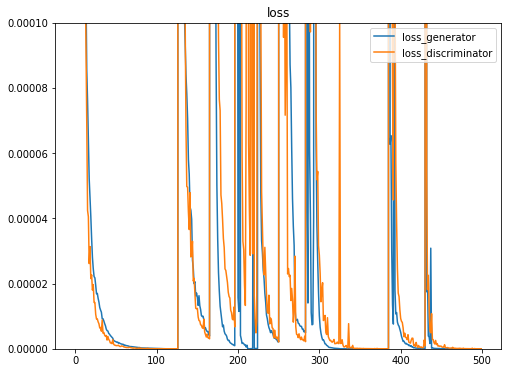

In [31]:
plt.figure(figsize=(8, 6))
plt.plot(loss_generator, label='loss_generator')
plt.plot(loss_discriminator, label='loss_discriminator')
plt.ylim(0,0.0001)
plt.legend()
plt.title('loss')
plt.show()

---

# functions for presenting the results

---

In [20]:
def function_result_01():

    num_latent_visualize = 16

    latent_visualize = torch.randn(num_latent_visualize, dim_latent, device=device)
    latent_visualize = torch.reshape(latent_visualize, [num_latent_visualize, dim_latent, 1, 1]) 

    prediction = compute_prediction(generator, latent_visualize)
    prediction = prediction.squeeze(axis=1)
    prediction_binary = (prediction >= 0.5)
    bounding_mask = compute_bounding_mask(prediction_binary)
        
    fake = prediction.detach().cpu()
    mask = bounding_mask.detach().cpu()

    nRow = 4
    nCol = 4 
    size = 3 
    
    title = 'fake image'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow): 
        for c in range(nCol):
            k = c + r * nCol
            axes[r, c].imshow(fake[k], cmap='gray', vmin=0, vmax=1)
            axes[r, c].xaxis.set_visible(False)
            axes[r, c].yaxis.set_visible(False)

    plt.tight_layout()
    plt.show()
    
    title = 'bounding mask'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow): 
        for c in range(nCol):
            k = c + r * nCol
            axes[r, c].imshow(mask[k], cmap='gray', vmin=0, vmax=1)
            axes[r, c].xaxis.set_visible(False)
            axes[r, c].yaxis.set_visible(False)
                        
    plt.tight_layout()
    plt.show()

In [21]:
def function_result_02():

    title           = 'accuracy'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'accuracy'
    
    plt.figure(figsize=(8, 6))
    plt.title(title)
    
    plt.plot(accuracy_epoch)
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [22]:
def function_result_03():

    print('final accuracy = %9.8f' % (accuracy_epoch[-1]))

---

## results

---


################################################################################
#
# RESULT # 01
#
################################################################################



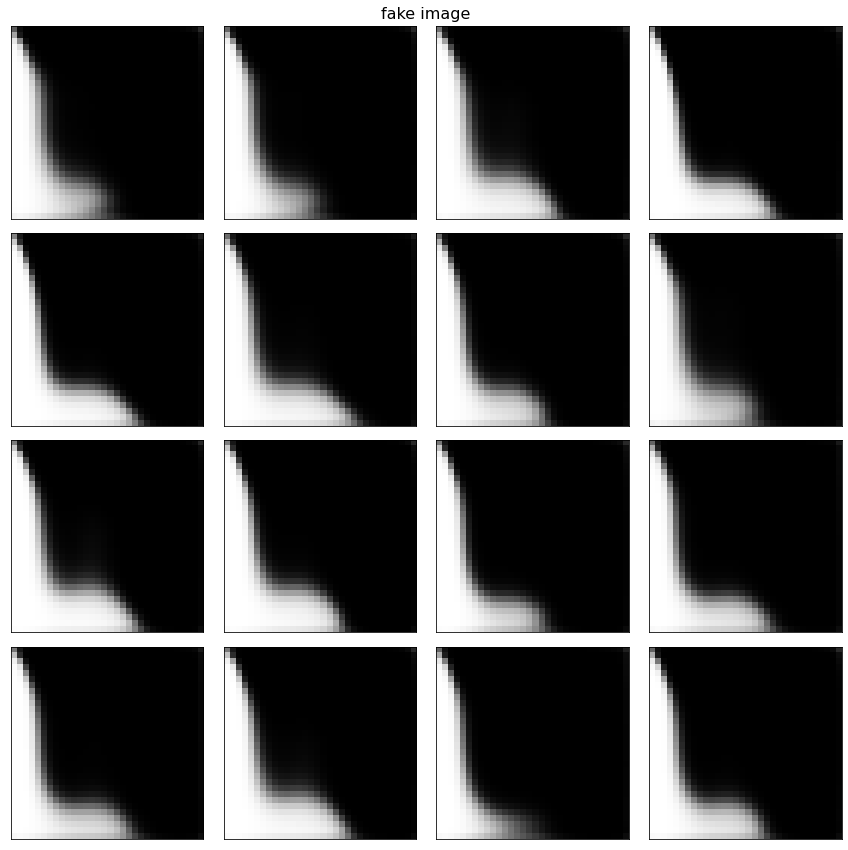

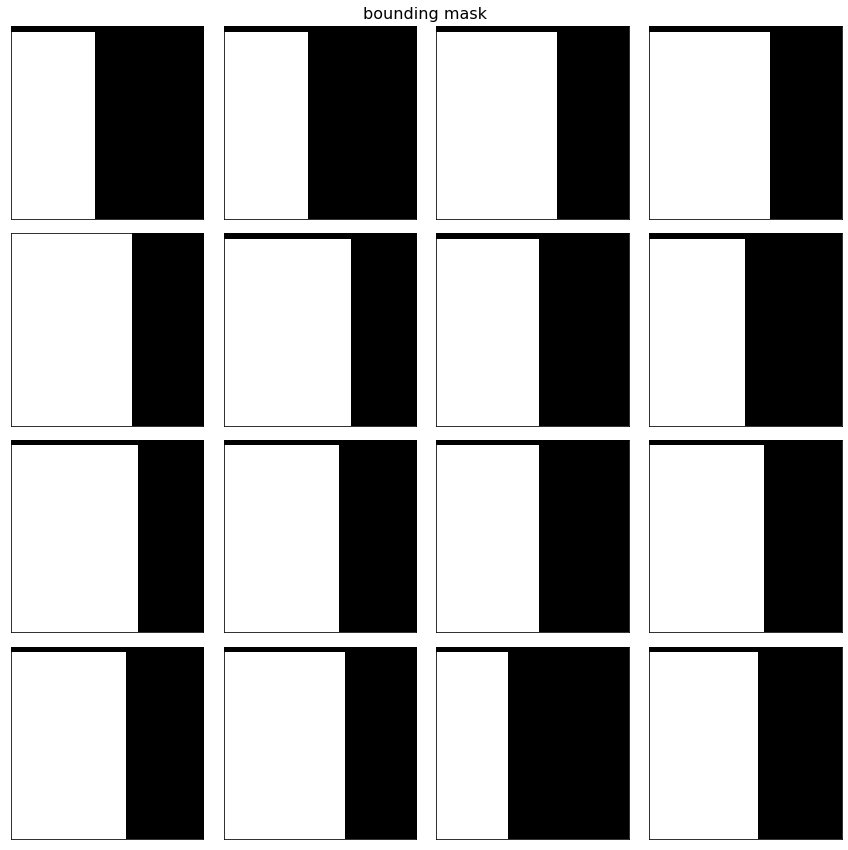


################################################################################
#
# RESULT # 02
#
################################################################################



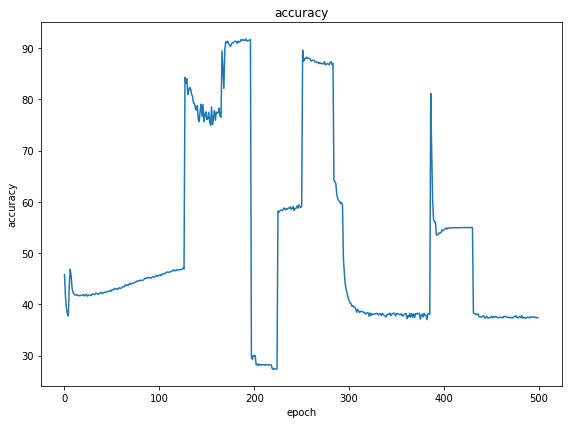


################################################################################
#
# RESULT # 03
#
################################################################################

final accuracy = 37.40739059


In [23]:
number_result = 3

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)